# Ancient Texts - Identifying Authorship of Ancient Hebrew Texts    

## By Rowana Ahmed, Sun Kim, Jie Sun, and Nellie Ponarul



### Table of Contents  
I. [Introduction](#intro)  
II. [Exploratory Analysis](#exploratory)   
III. [Embedding Generation](#embedding)  
IV. [Clustering](#clustering)  
  * A. [Spectral Clustering](#spectral)
  * B. [Agglomerative Clustering](#agg)    

V. [Evaluation](#eval)
  * A. [Supervised Label Prediction](#labels)
  * B. [Artifical Text Generation](#artifical)  

VI. [Results](#results)  
VII. [Discussion](#discussion)  


<a name='intro'></a>
### I. Introduction  


Hebrew biblical texts are considered composite documents. Scholars have various views towards the authorship of each book, and the construction of compositional layers. 

The traditional approach focuses on the linguistic evidence, such as the choice of phrases, differences in referencing names and plots, etc. For instance, the book of Genesis appears to be written by different authors, since ‘God’ was sometimes referred to as ‘Lord God’, and the sequences of objects created differ across chapters. However, there is no consensus on whether these linguistic characteristics indeed suggest different authorships, or how many authors are involved. 

In this project, we will explore a quantitative approach using data science. To determine whether a word, a verse or a chapter belongs to a particular author, we face several challenges: 
(1) Because this is unsupervised text classification, there is no labeled training data. 
(2) The exact number of authors is unknown, although scholars have theories which we will leverage in our validation process. 
(3) The hebrew texts were ‘old’ hebrew without any vowels. Embeddings thus need to be trained without access to powerful pre-trained models such as GPT-2. 

Therefore, the key challenge is to discover contextualized embeddings for the transcribed ‘old’ hebrew words and sentences. We then aim to answer the following questions:  

* What type of embedding best captures the style of each Biblical verse?  Can an automated approach perform as well as manual methods used in previous research?
* How many authors wrote each of the first five books of the Bible?  

#### The Data  

The data we are using to answer this problem is a Latin encoded transcript of the Hebrew bible written in old Hebrew, which omits vowels. We are using the first five books of the Hebrew bible, as these are typically attributed to one author, although scholars have reason to believe these books were written by multiple authors.

The data format is a text format that has in each line: the book name, chapter number, verse number, and the associated verse text. There is no punctuation that we need to clean from our data, and we will be splitting each verse on space to tokenize our data.

A few challenges that we encountered with the data were our lack of familiarity with the Hewbrew language, and the transliteration of Biblical Hebrew into Latin alphabet, which made it more difficult to comprehend the structure of a biblical verse.


<a name='exploratory'></a>  
### II. Exploratory Analysis 

##### i. Load Dependencies

In [ ]:
# import the necessary libraries
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' #Trying to reduce tensorflow warnings
import re
import math
import string
import json
import time
import random
import multiprocessing as mp

# useful structures and functions for experiments 
from collections import Counter
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy
from scipy.spatial import distance
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as hac

from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

# specific machine learning functionality
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
#from transformers import GPT2Tokenizer, TFGPT2LMHeadModel


#nltk.download('punkt')
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### ii. Load and pre-process data

In [ ]:
project_directory = 'drive/MyDrive/CS109B Final Project/'

In [ ]:
df = pd.read_csv(project_directory + 'bhs_novowels.txt',
                 sep=r'^(\w+\s*\w+)\s(\d+):(\d+)', 
                 engine='python', encoding = 'Latin1',
                 header=None).drop(columns=[0])

# create id columns
df['id'] = df[1] + df[2].astype(str) + '_' + df[3].astype(str)

# parse out chapter from id column
df['chapter'] = df['id'].str.extract(r'(\d+)')

# drop unused columns and rename columns
df = df.drop(columns=[2,3]).rename(columns={1: 'book', 4: 'text'})

# reverse text
df['text'] = df['text'].apply(lambda x: x[::-1]).str.strip()


# change order of columns
cols = ['id', 'chapter', 'book', 'text']
df = df[cols]

In [ ]:
df.head(5)

id chapter book                                               text
0  Gen1_1       1  Gen                 bravyt bra alhy~ at hvmy~ wat har#
1  Gen1_2       1  Gen  whar# hyth thw wbhw wxv$ [l-pny thw~ wrwx alhy...
2  Gen1_3       1  Gen                       wyamr alhy~ yhy awr wyhy-awr
3  Gen1_4       1  Gen  wyra alhy~ at-hawr ky-jwb wybdl alhy~ by! hawr...
4  Gen1_5       1  Gen  wyqra alhy~ lawr yw~ wlxv$ qra lylh wyhy-[rb w...

We create a subset of the data to include the first five books, i.e. the Pentateuch, as `df_first_5`.

In [ ]:
# Book subsets
first_5_book_titles = ['Gen', 'Exo', 'Lev', 'Num', 'Deu']
df_first_5 = df.loc[df.book.isin(first_5_book_titles)]

#### iii. Text Structure  

We summarize the number of books and verses across the Hebrew bible.

In [ ]:
print('The number of books in the Hebrew Bible is: ', len(set(df.book)))
print('The number of verses in the Hebrew Bible is: ', len(set(df.id)))
print('The maximum verse length in the Hebrew Bible is: ', max([len(t.split()) for t in df.text]))  

print('The number of books in the first five books of the Hebrew Bible is: ', len(set(df_first_5.book)))
print('The number of verses in the first five books of the Hebrew Bible is: ', len(set(df_first_5.id)))
print('The maximum verse length in the first five books of the Hebrew Bible is: ', max([len(t.split()) for t in df_first_5.text]))

The number of books in the Hebrew Bible is:  39
The number of verses in the Hebrew Bible is:  23213
The maximum verse length in the Hebrew Bible is:  36
The number of books in the first five books of the Hebrew Bible is:  5
The number of verses in the first five books of the Hebrew Bible is:  5853
The maximum verse length in the first five books of the Hebrew Bible is:  29


#### iv. Word Frequencies  

We looked at the word counts across the first five books of the Bible to determine if there are any patterns that might be relevant to our embeddings.

In [ ]:
def get_word_counts(df):
  word_counts = Counter()
  df['text'].str.lower().str.split().apply(word_counts.update)
  df_word_counts = pd.DataFrame.from_dict(word_counts, orient='index').reset_index() \
                   .rename(columns={'index': 'word', 0:'count'}) \
                   .sort_values('count', ascending=False)
  return df_word_counts


df_word_counts_first_5 = get_word_counts(df_first_5)

VOCAB_SIZE_FIVE_BKS = len(df_word_counts_first_5.index)

In [ ]:
print('The vocab size for the first five books in the Hebrew text: ', len(df_word_counts_first_5))
print('The number of tokens in first five books in the Hebrew text: ', sum(df_word_counts_first_5['count']))

The vocab size for the first five books in the Hebrew text:  17247
The number of tokens in first five books in the Hebrew text:  69161


For the first five books, we investigate how many books each word appears in, and create a frequency distribution of this.  

In [ ]:
# Plot to display how many books each word appears in
verses_5 = [v.split() for v in df_first_5['text']]
word_verse_5 = {}
for w in df_word_counts_first_5['word']:
  # For each word, get the set of books the word appears in by iterating through verses
  word_verse_5[w] = len(list(set([df_first_5['book'][i] for i,l in enumerate(verses_5) if w in l ])))

Text(0.5, 1.0, 'Distribution of Book Frequency of Each Word\n First 5 Books')

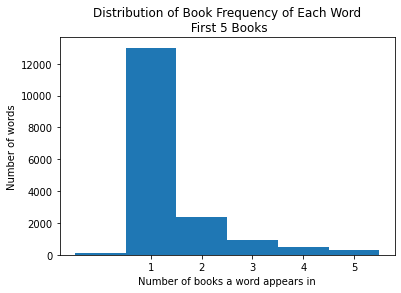

In [ ]:
plt.xticks(np.arange(1, 6))
plt.hist([v for v in word_verse_5.values()], bins = np.arange(7)-0.5)
plt.xlabel('Number of books a word appears in')
plt.ylabel('Number of words')
plt.title('Distribution of Book Frequency of Each Word\n First 5 Books')

We create a similar frequency distribution of the number of books a word appears in across all books of the Hebrew Bible. It is interesting to note that a large proportion of words are only present in a single book, which may indicate that many of the words in the corpus are in reference to proper nouns (individuals and locations) and may be very topic specific. If this is the case, this will pose an issue in distinguishing authorship based on writing style if the most salient signals in the data is focused on semantics.

In [ ]:
word_counts = Counter()
df['text'].str.lower().str.split().apply(word_counts.update)
df_word_counts = pd.DataFrame.from_dict(word_counts, orient='index').reset_index() \
                   .rename(columns={'index': 'word', 0:'count'}) \
                   .sort_values('count', ascending=False)

In [ ]:
verses_full = [v.split() for v in df['text']]
word_verse_full = {}
for w in df_word_counts['word']:
  # For each word, get the set of books the word appears in by iterating through verses
  word_verse_full[w] = len(list(set([df['book'][i] for i,l in enumerate(verses_full) if w in l ])))

In [ ]:
plt.xticks(np.arange(0, 6))
plt.hist([v for v in word_verse_full.values()], bins = np.arange(7)-0.5)
plt.xlabel('Number of books a word appears in')
plt.ylabel('Number of words')
plt.title('Distribution of Book Frequency of Each Word\n All Books')

We then look at the most frequent words across the first five books

Text(0.5, 1.0, 'Histogram of top 30 most frequent words of the first 5 books of Hebrew Bible')

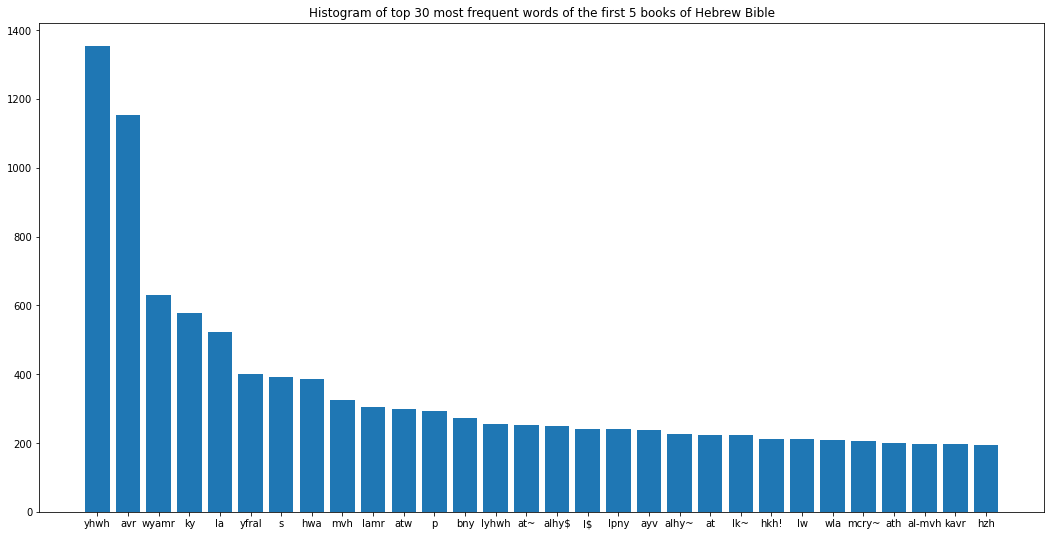

In [ ]:
fig = plt.figure(figsize = (18, 9))
plt.bar(df_word_counts_first_5['word'][:30], df_word_counts_first_5['count'][:30])
plt.title("Histogram of top 30 most frequent words of the first 5 books of Hebrew Bible")

We then look at the most frequent words across all of the books

Text(0.5, 1.0, 'Histogram of top 30 most frequent words of the Hebrew Bible')

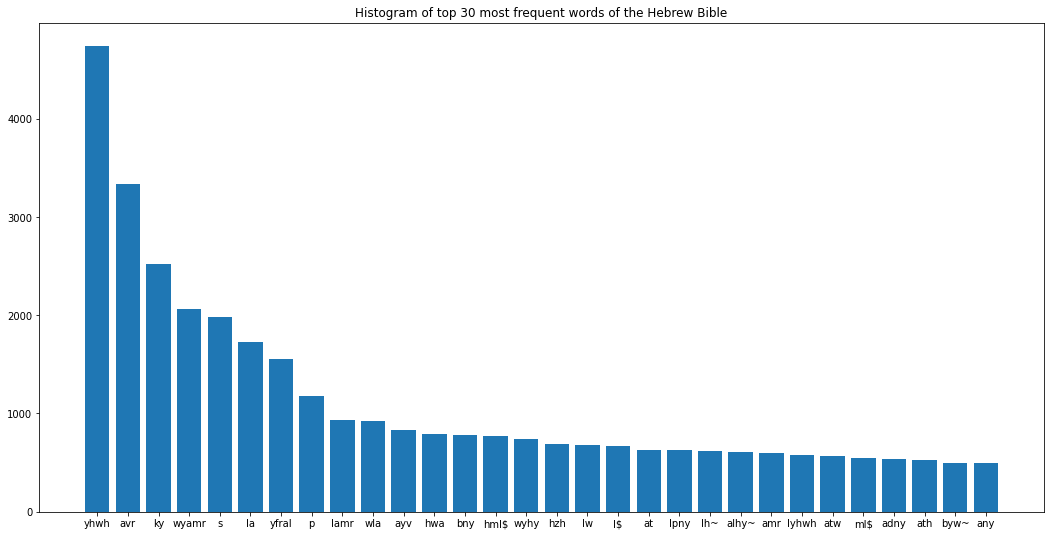

In [ ]:
fig = plt.figure(figsize = (18, 9))
plt.bar(df_word_counts['word'][:30], df_word_counts['count'][:30])
plt.title("Histogram of top 30 most frequent words of the Hebrew Bible")

<a name = 'embedding'></a>
### III. Embedding Generation  

Since we want to determine how many authors likely wrote the first five books of the Bible, we need to determine a way to cluster verses based on stylistic similarities. In order to do this, we first need to create a numerical representation of the Bible which captures similarities between verses.  

We will attempt to create this representation by trying out three different types of embeddings.  

* **Skip Gram Embedding**: Skip Gram is a type of word2vec embedding which captures verse structure. It is also an unsupervised learning method widely used to find similarity between words, since it assumes that words in close proximity are related. The goal is to expand word similarity from word level embeddings to capture similarity between Bible verses. For example, if an author tends to use similar phrasing across verses, then a skip gram embedding would capture this stylistic preference.  

* **LSTM Autoencoder Latent Space**: We will use an autencoder made up of a bidirectional LSTM layer to create a latent space that we hope will capture the stylistic similarities between verses. As we learned in class, autoencoders are trained to capture the most distinguishable features of a dataset in the latent space.

* **BERT Embedding**: BERT (Bidirectional Encoder Representations from Transformers) allows us to use transfer learning in NLP. We will use BERT to extract high quality language features from the text. As BERT is mostly trained on the English language, we will use the King James Version of the Hebrew Bible, and fine-tune it for the classification task later.  

#### Preprocessing  
To prepare the data for embedding, we encode our verses and pad them.

In [ ]:
# i. Split text to get vector of verses
# - Whole book
txt = [l.split() for l in df['text']]
# - First five books
txt_5 = [l.split() for l in df_first_5['text']]

# ii. Prepare to embed entire corpus
# - Get vocab
words = sorted(list(set([w for l in txt for w in l ])))
words.append("ENDPAD") # Encode an end pad key
n_words = len(words) # vocab size

To determine the maximum length of the sequence we want in our model, we first look at the distribution of verse length across the whole Bible.

Mean verse length:  11.494335070865464
Median verse length:  11.0


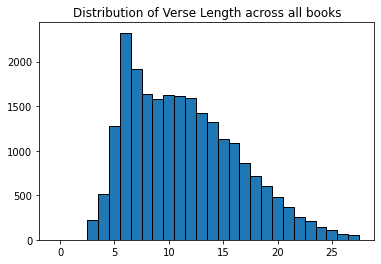

In [ ]:
plt.hist([len(v) for v in txt], bins = np.arange(29)-0.5, edgecolor="black")
plt.title('Distribution of Verse Length across all books')
print('Mean verse length: ', np.mean([len(v) for v in txt]))
print('Median verse length: ', np.median([len(v) for v in txt]))

The distribution of verse length is somewhat righ skewed with a mean and median around 11 words, and most verses are 7 words. Since we will need to pad our verses to the same length, we want to avoid having verses that are mostly made up of padding. Thus, we will consider the maximum verse length to be 15 words and truncate/pad verses as necessary.

In [ ]:
max_len_trunc = 15
word2idx = {word: i for i, word in enumerate(words)}
idx2word = {i:word for word, i in  word2idx.items()}

# Encode entire corpus
txt_encode = [[word2idx[w] for w in v] for v in txt]
X = pad_sequences(txt_encode, maxlen=max_len_trunc, padding = 'post', value = word2idx['ENDPAD'])

# # Encode the first 5 books using the whole corpus
txt_encode = [[word2idx[w] for w in v] for v in txt_5]
X_5 = pad_sequences(txt_encode, maxlen=max_len_trunc, padding = 'post', value = word2idx['ENDPAD'])

In [ ]:
# function to make PCA and tSNE plots
def make_plots(results, title, book):
  fig = plt.figure(figsize = (14, 8))
  labels = ['Gen','Exo','Lev','Num','Deu']
  book_idx_list = []
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  if book=='all':
    for book in labels:
      book_idx = np.where(np.array(df_first_5['book'])==book)
      book_idx_list.append(book_idx)
    for idx,label,color in zip(book_idx_list, labels, colors):
          x = results[:, 0][idx]
          y = results[:, 1][idx]
          plt.scatter(x, y, alpha=0.7, c=color.reshape(1,-1), label=label)
    plt.legend()
  else:
    book_idx = np.where(np.array(df_first_5['book'])==book)
    book_idx_list.append(book_idx)
    for idx in zip(book_idx_list):
          x = results[:, 0][idx]
          y = results[:, 1][idx]
          plt.scatter(x, y, alpha=0.7)

  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.title(title)

#### A. Skip Gram Embedding

To create the skip gram embedding, we create positive and negative word couples per verse with a window size of 2. We decided to create couplets independently per verse because it is possible that authorship could vary from verse to verse within a chapter, and so we do not want couplets to be created spanning multiple verses.

The skip gram embedding is trained on all 39 books in the Hebrew Bible corpus so it can generalize, and be used for validation on later books. The resulting word2vec emebddeding layer maps each word in the corpus to a 20 dimensional vector based on training with the skip gram positive/negative labels. 

In [ ]:
# build skipgram per verse
couples = []
labels = []
window_size = 2
# for verse in X5:
for verse in X:
  _couple, _label = tf.keras.preprocessing.sequence.skipgrams(verse, n_words, window_size=window_size)
  couples.append(_couple)
  labels.append(_label)

couples = np.concatenate(couples)
labels = np.concatenate(labels)

targets = []
contexts = []
for target_word, context_word in couples:
    targets.append(target_word)
    contexts.append(context_word)

In [ ]:
BATCH_SIZE = 1024
TRAIN_SHUFFLE_BUFFER_SIZE = len(targets)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels)) \
                            .shuffle(buffer_size = TRAIN_SHUFFLE_BUFFER_SIZE) \
                            .batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
vector_dim = 20
learning_rate = 0.01 
epochs = 5


def build_word2vec_model(vocab_size, vector_dim):
    # Build the target word embedding
    word_model = Sequential() 
    word_model.add(tf.keras.layers.Embedding(vocab_size, vector_dim,input_length=1,name='embedding')) 
    word_model.add(tf.keras.layers.Reshape((vector_dim, ))) 

    # Build the context word embedding
    context_model = Sequential() 
    context_model.add(tf.keras.layers.Embedding(vocab_size, vector_dim, input_length=1,name='context')) 
    context_model.add(tf.keras.layers.Reshape((vector_dim,))) 

    # Take the dot product of the the target and context word
    dot_product = tf.keras.layers.dot([word_model.output, context_model.output], axes=1,
                                   normalize=False,name='dotproduct') 
    dot_product = tf.keras.layers.Dense(1,activation="sigmoid")(dot_product) 

    # Complete word2vec model
    model = tf.keras.models.Model(inputs=[word_model.input, context_model.input],outputs=dot_product)
    
    return model


def train_word_embedding(train_data,vector_dim, epochs,vocab_size):
  # Free up memory
  K.clear_session()
  # Build the model
  model = build_word2vec_model(vocab_size, vector_dim)
  # Print the model architecture
  print(model.summary())
  # Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) #
  # Loss
  loss = tf.keras.losses.binary_crossentropy
  # Compile
  model.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])

  # Train model
  start_time = time.time()
  training_results = model.fit(
          train_data,
          epochs=epochs, 
          verbose=1)
  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)
  return model

In [ ]:
# train word embeddings from skip-gram
word_embedding_model = train_word_embedding(train_data, vector_dim,epochs, n_words)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        1153960     embedding_input[0][0]            
__________________________________________________________________________________________________
context (Embedding)             (None, 1, 20)        1153960     context_input[0][0]              
______________________________________________________________________________________________

In [ ]:
# save skipgram word embedding model
#word_embedding_model.save(project_directory + 'word_embedding_model_skipgram')

In [ ]:
# load word embedding model
word_embedding_model = keras.models.load_model(project_directory + 'word_embedding_model_skipgram')

In [ ]:
word2vec_embedding = word_embedding_model.get_layer('embedding').embeddings
embedding_layer_weights = word2vec_embedding.numpy()
print(word2vec_embedding.shape)

(57698, 20)


##### i. Aggregate word embeddings to verse embeddings

There are many ways to aggregate word embeddings to form verse embeddings. As previously mentioned, the idea is to use word similarity to obtain similarity between sentences (i.e. Bible verses). Common ways to calculate this "sentence embedding" is to take the average or sum of embedding vectors of the words in a sentence. In the literature, using average, rather than sum, of word2vec vectors is more common because we do not want the length of a sentence to indicate similiarity.

In [ ]:
num_verses, max_verse_len = X_5.shape
sentence_embedding = word2vec_embedding.numpy()[X_5.flatten(), :].reshape(num_verses, max_verse_len, -1)

sentence_embedding_mean = sentence_embedding.mean(axis=1)
sentence_embedding_mean.shape

(5853, 20)

Another form of verse level aggregation is to consider concatanating or flattening the word level embedding to calculate the verse level embedding. This method allows for the order of words to be maintained in the embedding information, which is lost if the mean or sum aggregation method is employed. 

In [ ]:
sentence_embedding_concat = sentence_embedding.reshape(num_verses, - 1)
sentence_embedding_concat.shape

(5853, 300)

The plots below compare the clusters that result when using the two different aggregation methods in the reduced PCA and t-SNE space.

The concatantion method seems to result in more patterned grouping in both the PCA and t-SNE space than the mean aggregation method, and so we believe this aggregation method will perform better in clustering algorithms. 

In [ ]:
# Fit PCA and tSNE for mean aggregation method
pca = PCA(n_components = 2)
PCA_results_mean = pca.fit_transform(sentence_embedding_mean)
tsne = TSNE(n_components = 2)
tsne_results_mean = tsne.fit_transform(sentence_embedding_mean)


# Fit PCA and tSNE for concatanation aggregation method
pca = PCA(n_components = 2)
PCA_results_concat = pca.fit_transform(sentence_embedding_concat)
tsne = TSNE(n_components = 2)
tsne_results_concat = tsne.fit_transform(sentence_embedding_concat)

Percent of variance explained:  0.057881579734385014


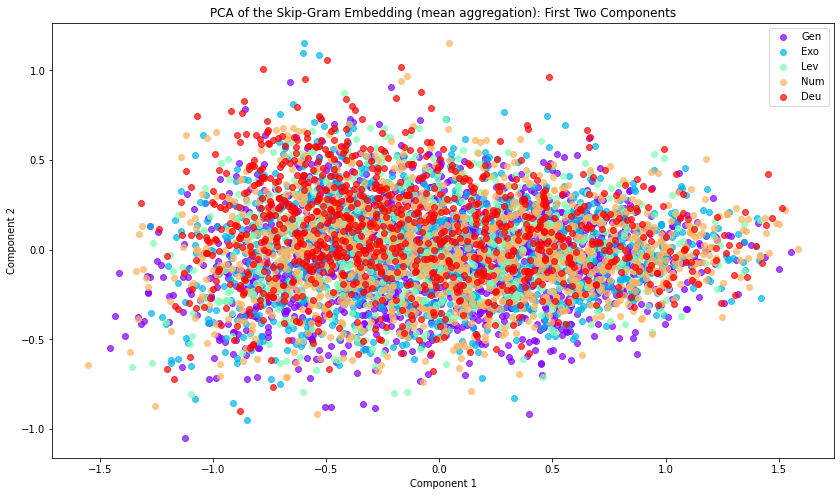

In [ ]:
# Plot PCA
make_plots(PCA_results_mean, 'PCA of the Skip-Gram Embedding (mean aggregation): First Two Components', 'all')
print("Percent of variance explained: ", sum(pca.explained_variance_ratio_))

Percent of variance explained:  0.057881579734385014


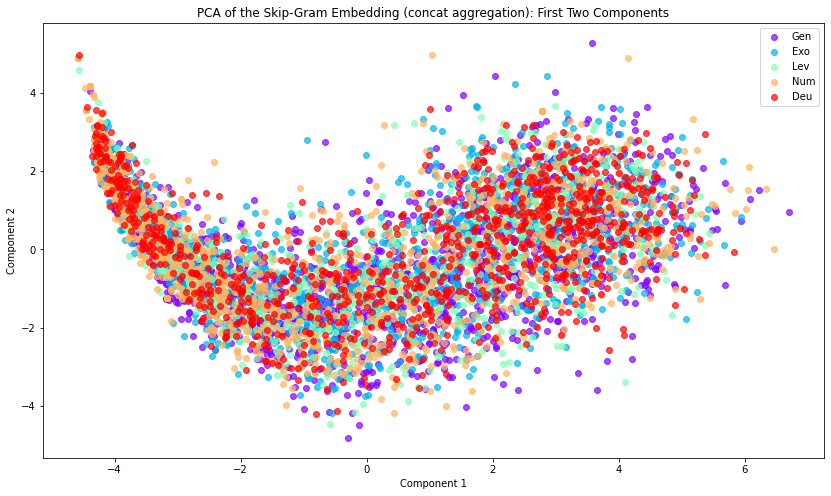

In [ ]:
# Plot PCA
make_plots(PCA_results_concat, 'PCA of the Skip-Gram Embedding (concat aggregation): First Two Components', 'all')
print("Percent of variance explained: ", sum(pca.explained_variance_ratio_))

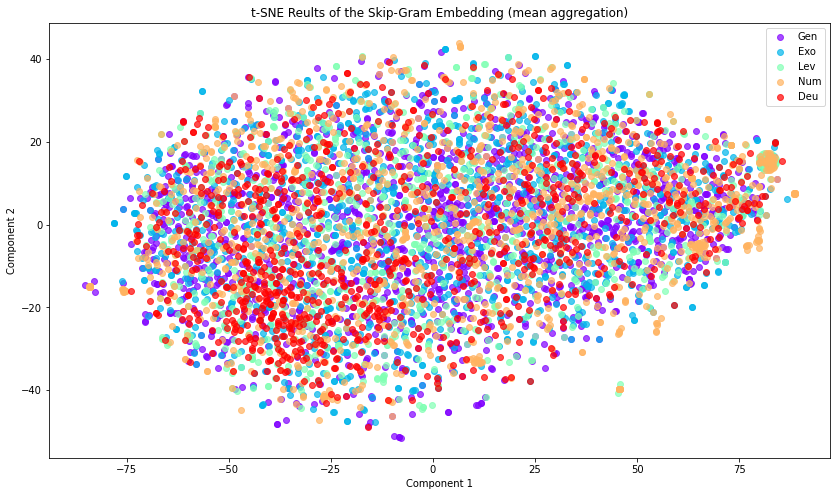

In [ ]:
# Plot tSNE
make_plots(tsne_results_mean, 't-SNE Reults of the Skip-Gram Embedding (mean aggregation)', 'all')

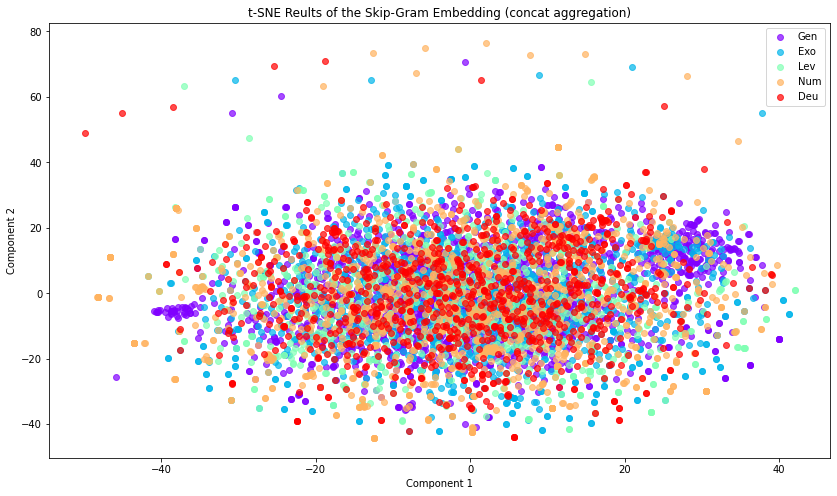

In [ ]:
# Plot tSNE
make_plots(tsne_results_concat, 't-SNE Reults of the Skip-Gram Embedding (concat aggregation)', 'all')

#### B. LSTM Autoencoder Embedding      

To create the LSTM autoencoder embedding we first create an initial embedding using the keras Embedding layer with an embedding dimension of 50. Then, we train an autoencoder to learn the structure of this embedding, using a bidirectional LSTM layer with 20 units as both the encoder and decoder structure. 

Note that both the initial embedding and autoencoder are trained on the entire Ancient Hebrew bible (all 39 books). We did this so that our embeddings would be generalizable. In order to get a sense of the number of authors in the first five books, we will subset the latent space trained on the whole Bible to just the first five books.

We referenced [this article](https://machinelearningmastery.com/lstm-autoencoders/) in our approach to creating this autoencoder and also how to access the output of the encoder as the latent space representation, which is ultimately the embedding on which we will try to determine the number of authors.

In [ ]:
# First Create Embedding to pass into the autoencoder. 
# This is crucial so that the model learns the features of this intial embedding.
embed_dim_LSTM = 50

embed_model = tf.keras.Sequential()
embed_model.add(tf.keras.layers.Embedding(input_dim = n_words, output_dim = embed_dim_LSTM, input_length = max_len_trunc))
embed_model.compile('adam', 'mse')
embed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 50)            2884900   
Total params: 2,884,900
Trainable params: 2,884,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Save and load embedding model 
# embed_model.save('drive/MyDrive/CS109B Final Project/LSTM_embedding_model/embedding/')
embed_model = keras.models.load_model('drive/MyDrive/CS109B Final Project/LSTM_embedding_model/embedding/')

In [ ]:
# Embed the whole corpus with the Embedding
embed_X = embed_model.predict(X) 
# Subset the embedding to get the first five books
embed_X_5 = embed_X[np.where(df['book'].isin(first_5_book_titles)), :][0]
print('Dimensions of initial embedding of full corpus is: ', embed_X.shape)
print('Dimensions of initial embedding of first five books is: ', embed_X_5.shape)

Dimensions of initial embedding of full corpus is:  (23213, 15, 50)
Dimensions of initial embedding of first five books is:  (5853, 15, 50)


In [ ]:
# Define the LSTM autoencoder
embed_dim_LSTM = 50
autoencoder = Sequential()
autoencoder.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, activation = 'linear', input_shape=(max_len_trunc,embed_dim_LSTM))))
autoencoder.add(tf.keras.layers.RepeatVector(max_len_trunc))
autoencoder.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,  activation = 'linear', return_sequences=True)))
autoencoder.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(embed_dim_LSTM)))
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# autoencoder.fit(embed_X, embed_X, epochs = 10, batch_size = 200)

Epoch 1/10
117/117 [==============================] - 16s 83ms/step - loss: 7.2703e-04
Epoch 2/10
117/117 [==============================] - 10s 82ms/step - loss: 6.2668e-04
Epoch 3/10
117/117 [==============================] - 10s 85ms/step - loss: 6.1778e-04
Epoch 4/10
117/117 [==============================] - 10s 83ms/step - loss: 6.1053e-04
Epoch 5/10
117/117 [==============================] - 10s 84ms/step - loss: 6.0468e-04
Epoch 6/10
117/117 [==============================] - 10s 85ms/step - loss: 5.9358e-04
Epoch 7/10
117/117 [==============================] - 10s 85ms/step - loss: 5.8975e-04
Epoch 8/10
117/117 [==============================] - 10s 83ms/step - loss: 5.8517e-04
Epoch 9/10
117/117 [==============================] - 10s 84ms/step - loss: 5.8161e-04
Epoch 10/10
117/117 [==============================] - 10s 86ms/step - loss: 5.7878e-04


In [ ]:
# autoencoder.save('drive/MyDrive/CS109B Final Project/LSTM_embedding_model/autoencoder2/')

INFO:tensorflow:Assets written to: drive/MyDrive/CS109B Final Project/LSTM_embedding_model/autoencoder2/assets


In [ ]:
 autoencoder = keras.models.load_model('drive/MyDrive/CS109B Final Project/LSTM_embedding_model/autoencoder2/')
 autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 40)                11360     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 15, 40)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 15, 40)            9760      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 50)            2050      
Total params: 23,170
Trainable params: 23,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Look at the fit of the model
autoencoder.evaluate(embed_X)

726/726 [==============================] - 4s 5ms/step - loss: 0.0000e+00


0.0

In order to prepare for clustering, we need to extract the latent space output.

In [ ]:
# Get latent space
autoencoder_latent = tf.keras.models.Model(inputs = autoencoder.input, outputs = autoencoder.layers[0].output)
autoencoder_latent.summary()
latent_LSTM = autoencoder_latent.predict(embed_X)
print(latent_LSTM.shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4_input (Input [(None, 15, 50)]          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40)                11360     
Total params: 11,360
Trainable params: 11,360
Non-trainable params: 0
_________________________________________________________________
(23213, 40)


In [ ]:
# Get the first five books
latent_LSTM_5 = latent_LSTM[np.where(df['book'].isin(first_5_book_titles)), :][0]

In [ ]:
# Fit PCA and tSNE
pca = PCA(n_components = 2)
PCA_results1 = pca.fit_transform(latent_LSTM_5)
tsne = TSNE(n_components = 2)
tsne_results1 = tsne.fit_transform(latent_LSTM_5)

Percent of variance explained:  0.758841872215271


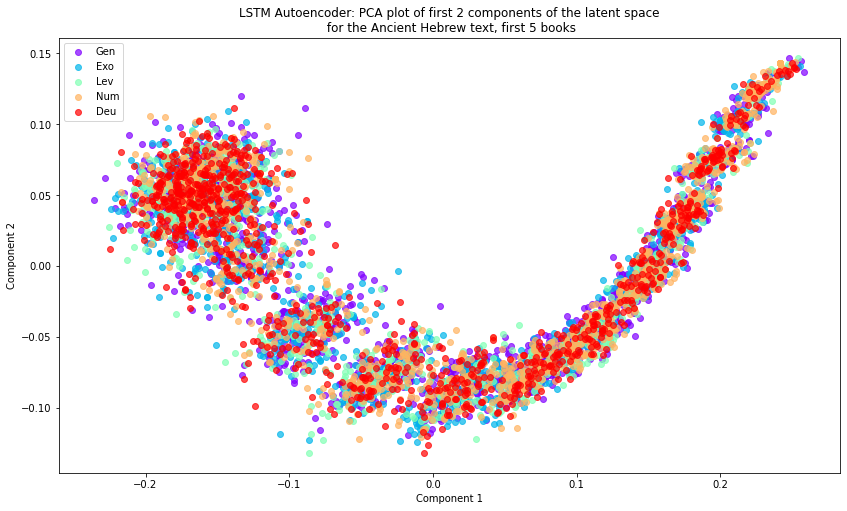

In [ ]:
# Plot PCA
make_plots(PCA_results1, 'LSTM Autoencoder: PCA plot of first 2 components of the latent space\n for the Ancient Hebrew text, first 5 books', 'all')
print("Percent of variance explained: ", sum(pca.explained_variance_ratio_))

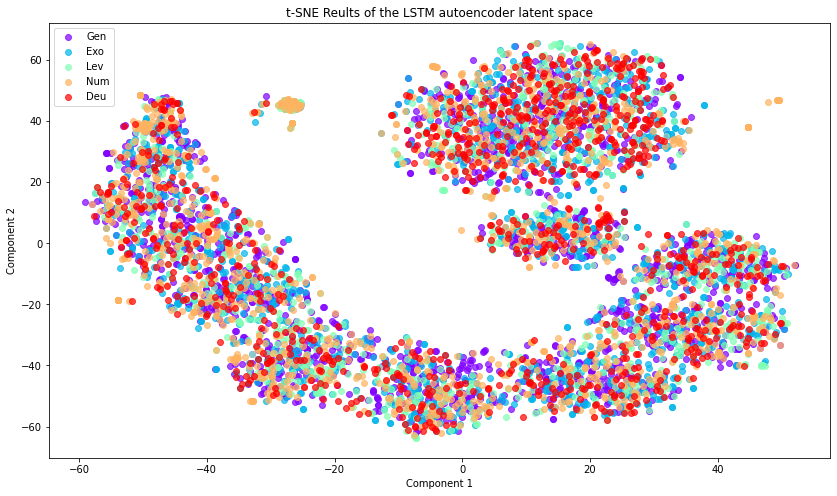

In [ ]:
# Plot tSNE
make_plots(tsne_results1, 't-SNE Reults of the LSTM autoencoder latent space', 'all')

The first two principal components of the latent space of the LSTM autoencoder capture about 76% of the variability in the data. We see some kind of streak pattern in the PCA plot, and slight separation of some small clusters  

The tSNE plot of the latent space has a similar stream pattern with several loosely clumped points that span all five books. There is one clump that is much larger than the others. From the tSNE plot it is difficult to determine if any one book is more clustered together than the others.

#### C. BERT Embedding

We will use the pytorch package to obtain verse embeddings with BERT. Since BERT is trained on English, we have used the King James Version of the Hebrew Bible. 

In fact, we have also experimented creating the BERT embeddings on the Hebrew text, however it did not perform very well, so we are only showing the attempt with the English text. 

In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 8.2MB/s 
     |████████████████████████████████| 3.3MB 17.4MB/s 
     |████████████████████████████████| 901kB 53.9MB/s 


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
import time
import babel
import os
import pathlib

In [ ]:
# Tokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [ ]:
def text_to_embedding(tokenizer, model, in_text):
    
    #1. tokenization ===================
    max_len = 152 #longest verse

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len + 2  # Pad & truncate all sentences.
                   )

    # pad our input tokens
    # pad_sequences expects a list of lists. If have only 1 piece of text,
    # use [input_ids] instaed
    results = pad_sequences([input_ids],
                           maxlen = max_len,
                           dtype = 'long',
                           truncating = 'post',
                           padding = 'post')
    
    # remove the outer list
    
    input_ids = results[0]
    
    # create attention masks
    attn_mask = [int(i>0) for i in input_ids]
    
    # cast to tensors
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)
    
    # add extra dimension for the 'batch', although there's only 1 input in this batch
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)
    
    #2. bert ===================
    model.eval()
    
    with torch.no_grad():
        # forward pass, return hidden states and predictions
        # this will return logits rather than the loss beause we have 
        # not provided labels

        outputs = model(
        input_ids = input_ids,
        token_type_ids = None,
        attention_mask = attn_mask)
    
        encoded_layers = outputs[2]
    #retrieve sentence embedding - take the '[CLS]' embedding from the final layer
    layer_i = 12 # the last bert layer before the classifier
    batch_i = 0 # only one input in the batch
    token_i = 0 # the 1st token, corresponding to [CLS]
    
    #grab the embedding
    vec = encoded_layers[layer_i][batch_i][token_i]
    
    #to numpy ndarray
    vec = vec.numpy()
    
    return(vec)

In [ ]:
# Load the KJV version bible

df_kjv = pd.read_csv(project_directory + 'kjv.txt',sep=r'^(\w+\s*\w+)\s(\d+):(\d+)', engine='python', header=None) \
       .drop(columns=[0])
# create id columns
df_kjv['id'] = df_kjv[1] + df_kjv[2].astype(str) + '_' + df_kjv[3].astype(str)

# drop unused columns and rename columns
df_kjv = df_kjv.drop(columns=[2,3]).rename(columns={1: 'book', 4: 'text'})

# change order of columns
cols = ['id', 'book', 'text']
df_kjv = df_kjv[cols]
df_kjv.head()

id book                                               text
0  Gen1_1  Gen   In the beginning God created the heaven and t...
1  Gen1_2  Gen   And the earth was without form, and void; and...
2  Gen1_3  Gen   And God said, Let there be light: and there w...
3  Gen1_4  Gen   And God saw the light, that [it was] good: an...
4  Gen1_5  Gen   And God called the light Day, and the darknes...

In [ ]:
# first 5
df_first_5_kjv = df_kjv.loc[df_kjv.book.isin(['Gen', 'Exo', 'Lev', 'Num', 'Deu'])]

In [ ]:
# Initialize the model
model_kjv = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_kjv.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Convert all verses of KJV bible to embeddings

# track the time
t0 = time.time()

# store the set of embeddings
bible_embeddings_kjv = []
num_verse = len(df_kjv)
print('Generating sentence embeddings for all {:,} verses...'.format(num_verse))

row_num = 0

# for each row of the dataframe
for index, row in df_kjv.iterrows():
    
    #progress report every 2000 verses
    if row_num % 2000 == 0 and not row_num == 0:
        #calculate time remaining based on progress
        rows_per_sec = (time.time()-t0)/row_num
        remaining_sec = rows_per_sec*(num_verse - row_num)
        print('Verse{:>7,} of {:>7,}. Remaining:{:} seconds'.format(row_num,num_verse,remaining_sec))
        
    #vectorize the verse
    vec = text_to_embedding(tokenizer, model_kjv,row.text)
    
    #store the embeddings
    bible_embeddings_kjv.append(vec)
    
    row_num += 1

# convert list of vectors into a 2D array
vecs_kjv = np.stack(bible_embeddings_kjv)
vecs_kjv.shape

# save those embeddings
output_dir = project_directory +'/bert_embeddings/'
print('Output directory is: ', output_dir)

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# use numpy to write out the matrix of embeddings
print('Saving embeddings to: ./bert_embeddings/embeddings_kjvfull.npy')
file_name = output_dir + 'embeddings_kjvfull.npy'
np.save(file_name, vecs_kjv)


In [ ]:
# load the embeddings

embeddings_kjvfull = project_directory +'/bert_embeddings/embeddings_kjvfull.npy'
embeddings_kjvfull = np.load(embeddings_kjvfull)

We have also produced a subset of embeddings for the first 5 books, using exactly the same method above. For simplicity, we have omitted the duplicated code, and will load the embeddings directly below: 

In [ ]:
# load the embeddings for the first 5 books
embeddings_first_5_kjv = project_directory +'/bert_embeddings/embeddings_first_5_kjv.npy'
embeddings_first_5_kjv = np.load(embeddings_first_5_kjv)

In [ ]:
# function to make PCA and tSNE plots

def make_plots_bert(results, title,df,labels):
  fig = plt.figure(figsize = (18, 12))
  book_idx_list = []
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))

  for book in labels:
    book_idx = np.where(np.array(df['book'])==book)
    book_idx_list.append(book_idx)
  
  for idx,label,color in zip(book_idx_list, labels, colors):
        x = results[:, 0][idx]
        y = results[:, 1][idx]
        plt.scatter(x, y, alpha=0.7, c=color.reshape(1,-1), label=label)
  plt.legend()
  plt.xlabel('Component 1',fontsize = 20)
  plt.ylabel('Component 2',fontsize = 20)
  plt.title(title,fontsize = 20)

Percent of variance explained:  [4.968553 4.106681]


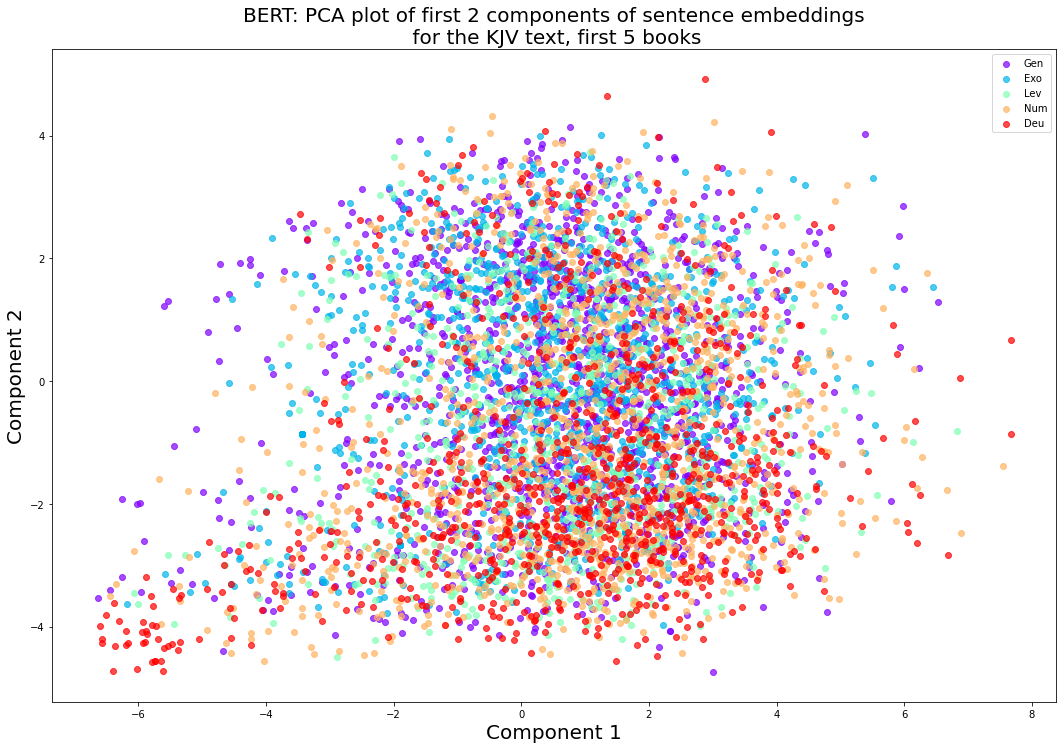

In [ ]:
# perform PCA
pca = PCA(n_components=2)
pca_result_kjv = pca.fit_transform(embeddings_kjvfull)

print("Percent of variance explained: ", pca.explained_variance_)
labels = ['Gen','Exo','Lev','Num','Deu']
make_plots_bert(pca_result_kjv, 
                'BERT: PCA plot of first 2 components of sentence embeddings\n for the KJV text, first 5 books',
                df_kjv,
               labels)

PCA suggests that the first 2 PCs explained about 10% of the total variations in the embeddings. But we do not see a clear separation of clusters (i.e. Books). Similar to the PCA plots with Skip-gram and LSTM embeddings, the points with different books in the Pentateuch are cluttered together. 

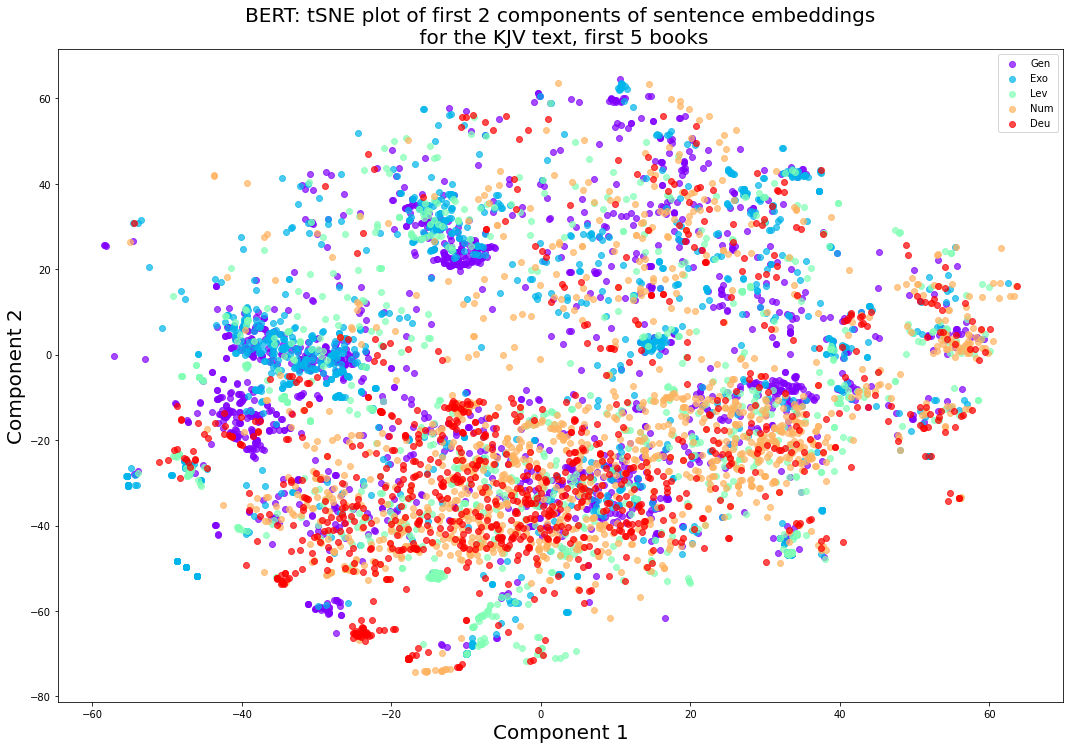

In [ ]:
# perform TSNE
tsne = TSNE(n_components = 2)
tsne_results_kjv = tsne.fit_transform(embeddings_kjvfull)
labels = ['Gen','Exo','Lev','Num','Deu']
make_plots_bert(tsne_results_kjv, 
                'BERT: tSNE plot of first 2 components of sentence embeddings\n for the KJV text, first 5 books',
                df_kjv,
               labels)

TSNE plot shows better separation between the 5 books than PCA. For example, Exodus and Deuteronomy are perhaps having very different embeddings, as the blue and red dots are mostly separated. 

Numbers and Deuteronomy share similar space, suggesting that these 2 books may be either style-wise or content-wise similar.  

We will exploit these 3 embeddings in the next section, and see which one offers more convincing conclusions on the authorship. 

<a name = 'clustering'></a>
### IV. Clustering

Once the embeddings are generated, we perform clustering to group the verses into an appropriate number of groups corresponding to unique authors. We make use of two unsupervised clustering techniques (spectral clustering and agglomerative clsutering) and compare the results below for each of the embedding methods.  

<a name = 'spectral'></a>
#### A. Spectral Clustering  

Spectral clustering is a technique that considers the reduced eigenspace of a similarity matrix to cluster within instead of the original data space for improved clustering efficiency. The process also provides a heurestic to determine an appropriate k as described below. Spectral clustering includes the following steps:

1) Calculate a square similarity matrix (W) that represents the similarity between data points i and j. We consider the pairwise similarity between verses by calculating the distance between the embedded verse vectors. Several distance metrics are considered (cosine, correlation, L1 (cityblock), and L2 (euclidean) distances. The selection of an appropriate distance method varies per embedding type.

The distance metrics are then rescaled (e.g. w = $exp(\frac{-L2_{dist}^2}{-L2_{dist, mean}^2})$ ) so that similar verses have values close to 1 and verses that differ greatly have values closer to 0.  

2) Calculate the Diagonal matrix D, which is the sum of each row of matrix W.

3) Calculate the normalized Laplacian matrix, which is equal to $L_{norm} =  I-D^{-1}W$. This is an adaptation of the traditional Laplacian matrix used in graph theory (L = D - W) since the normalized Laplacian was found to be more efficient for clustering by [Von-Luxburg (2007) ](https://arxiv.org/abs/0711.0189).

4) Calculate the eigenvalues of L, and identify the 'spectral gap.'  This gap occurs when there is  a sharp jump in the eigenvalue magnitude, and according to spectral graph theory, **the location of this gap corresponds to the number of clusters present in the dataset**. For example, if there are 2 eigenvalues below this gap ($\lambda_{1} = 0 < \lambda_{2} << \lambda_{3} < ....\lambda_n)$, then the data can be appropriately clustered into k=2 groups, which would correspond to two unique authors for our problem.

5) Using the first k-1 eigenvectors of L, cluster the embedded verse vectors in this lower dimensional space using k-means. This reduced space based on the similarity matrix is much more efficient for the k-means algorithm than the original data space.

We use spectral clustering on each of our embeddings to determine the number of clusters in our data and to generate k-means labels.

In [ ]:
def spectral_clustering_find_k(embedding_weights, distance_method = 'euclid'):
  """
  generates a plot of eigenvalues to visually identify location of spectral gap & returns eigenvalue & eigenvector array that can be used for clustering in 
  eigenspace

  embedding_weights: 2D numpy matrix corresponding to verse level embedding 
  distance_method: method to calc similarity metric (e.g. euclid, cosine)
  """
  num_verses, _ = embedding_weights.shape

  # calculate pairwise distances between verses
  Y = distance.pdist(embedding_weights, distance_method)
  pair_distances = distance.squareform(Y)

  # calculate W matrix (similarity matrix - values close to 1 indicate similar vectors
  # and values close to 0 indicate greatest difference)
  if distance_method in ['euclid', 'cityblock']:
    sigma = np.mean(pair_distances.flatten())
    W = np.exp(-pair_distances**2/sigma**2) 
  elif distance_method in ['cosine', 'correlation']:
    W = 1 - pair_distances
  else:
    raise ValueError('unsupported distance method')

  # calculate Diagonal matrix
  D = np.diag(np.sum(W, axis = 0))

  # normalized laplacian
  L_norm = np.eye(num_verses) - scipy.linalg.inv(D)@W
  l_norm, V_norm = scipy.linalg.eig(L_norm)
  idx = l_norm.argsort()
  l_norm = l_norm[idx]
  V_norm = V_norm[:,idx]

  plt.plot(l_norm,'-x');
  plt.title('eigenvalues of Normalized Laplacian matrix');
  plt.tight_layout()

  return(l_norm, V_norm)

##### Spectral Clustering Example on Artifical Text

To take a quick look at spectral clustering in practice, we provide an example  using artificially constructed text. This text is produced by combining various books, each of which are believed by biblical experts to have been authored by a single individual. This validation check demonstrates the applicability of spectral clustering to our problem.

In [ ]:
df['verse'] = df['id'].apply(lambda x: x.split('_')[1])

def embed_artificial_text(X, book_list, df, word2vec_embedding):
  idx = df[df.book.isin(book_list)].index
  X_art = X[idx, :]
  num_verses, max_verse_len = X_art.shape
  sentence_embedding = word2vec_embedding.numpy()[X_art.flatten(), :].reshape(num_verses, max_verse_len, -1)
  sentence_embedding = sentence_embedding.reshape(num_verses, - 1) # concat word embeddings for verse level embeddings

  return sentence_embedding


Example A) When spectral clustering is conducted on Obadiah (a book considered to have one author)  represented with skip-gram embedding, there are no intermediate eigenvalues between the smallest eigenvalue of 0 and the point at which the remaining eigenvalues converge towards a single value. This implies that a single cluster is present in the underlying dataset.

In [ ]:
X_Art = embed_artificial_text(X, ['Oba' ], df, word2vec_embedding)
X_Art.shape

(21, 300)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


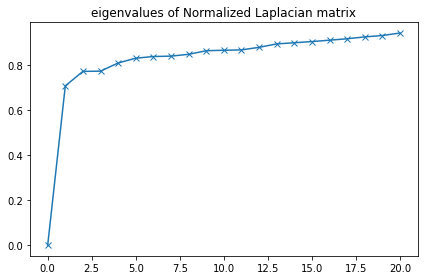

In [ ]:
eigenvals, eigenvectors = spectral_clustering_find_k(X_Art, 'cosine')

Example B) When an artificial text is constructed by combining the Book of Obadiah with the Book of Amos (each of which are believed to be authored by a single individual), there are two eigenvalues below the point where the remaining eigenvalues begin to converge towards a single value, indicating that there are two clusters present in the dataset. 

In [ ]:
X_Art = embed_artificial_text(X, ['Oba','Amo' ], df, word2vec_embedding)
X_Art.shape

(167, 300)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


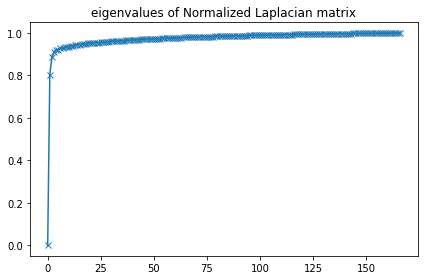

In [ ]:
eigenvals, eigenvectors = spectral_clustering_find_k(X_Art, 'cosine')

Example C) When the artificial text is augmented with the Book of Ezekiel (also believed to be authored by a single individual), there are 3 eigenvalues below the point of convergence indicating three distinct clusters in the underlying dataset.

In [ ]:
X_Art = embed_artificial_text(X, ['Oba','Amo', 'Eze' ], df, word2vec_embedding)
X_Art.shape

(1440, 300)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


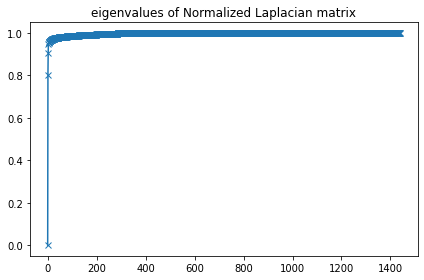

In [ ]:
eigenvals, eigenvectors = spectral_clustering_find_k(X_Art, 'cosine')

##### i. Skip Gram Embedding

To assess the number of authors for the first 5 books of the Hebrew bible, we perform spectral clustering on the eigenspace of the normalized Laplacian generated using the skip-gram embeddeding corresponding to the relevant verses. Based on the eigenvalue graph, the skip-gram embedded verses indicate that there are 3 clusters present, which could correspond to 3 unique authors. 

However, the third cluster might not be distinct since the 3rd eigenvalue is quite close to the converged values. In fact, the visualization of these clusters in the t-SNE space shows that the 3rd cluster is much smaller in size than the other two, possibly indicating two primary authors are responsible for the first 5 books, with contributions from a third minor author. 



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


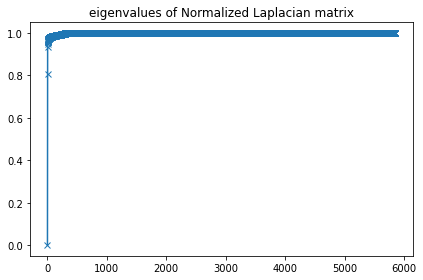

In [ ]:
eigenvals, eigenvectors = spectral_clustering_find_k(sentence_embedding_concat, 'cosine')

In [ ]:
# cluster in first K eigenvector space
k = 3

kmeans_skip3 = KMeans(n_clusters=k,
                n_init=5,
                copy_x=True).fit(np.real(eigenvectors[:,1:k]))
print(pd.Series(kmeans_skip3.labels_).value_counts())

kmeans_dist_skip3 = kmeans_skip3.transform(np.real(eigenvectors[:,1:k]))**2
kmeans_dist_skip3 = pd.DataFrame({'sqdist' : kmeans_dist_skip3.sum(axis = 1),
                                  'labels':kmeans_skip3.labels_})


0    2886
1    2308
2     659
dtype: int64


Text(0.5, 1.0, 'Pentateuch Spectral Clustering')

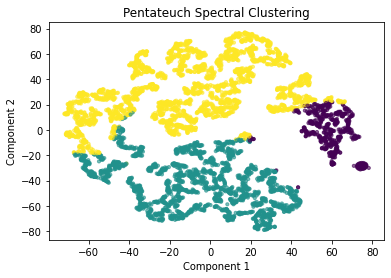

In [ ]:
# visualize clusters in t-SNE space
tsne_obj = TSNE(n_components = 2)
tsne_fit = tsne_obj.fit_transform(np.real(eigenvectors[:,1:k]))
    
x = tsne_fit[:, 0]
y = tsne_fit[:, 1]

# use cluster labels as color in plot
plt.scatter(x, y, alpha=0.6, c=kmeans_skip3.labels_, s=10)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Pentateuch Spectral Clustering')

In [ ]:
# for documentary hypothesis validation in Part V
# cluster in first K eigenvector space
# k = 4 

# kmeans_skip4 = KMeans(n_clusters=k,
#                 n_init=5,
#                 copy_x=True).fit(np.real(eigenvectors[:,1:k]))
# pd.Series(kmeans_skip4.labels_).value_counts()

# # Save out the squared distances from the centroids for future evaluation against documentary source
# kmeans_dist_skip4 = kmeans_skip4.transform(np.real(eigenvectors[:,1:k]))**2
# kmeans_dist_skip4 = pd.DataFrame({'sqdist' : kmeans_dist_skip4.sum(axis = 1), 
#                                   'labels':kmeans_skip4.labels_})


##### ii. LSTM Autoencoder Embedding  

We use spectral clustering with Euclidean distance to determine the number of clusters found in the LSTM autoencoder embedding space, using only the first five books.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


CPU times: user 6min 15s, sys: 38.7 s, total: 6min 54s
Wall time: 3min 45s


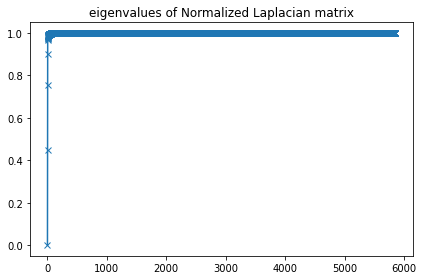

In [ ]:
%%time
eigenvals_LSTM, eigenvectors_LSTM = spectral_clustering_find_k(latent_LSTM_5, 'euclid')

This indicates 4 clusters, which indicates that spectral clustering is predicting 4 authors.


In [ ]:
# cluster in first K eigenvector space
k = 4

kmeans_LSTM_4 = KMeans(n_clusters=k,
                n_init=40,
                copy_x=True).fit(np.real(eigenvectors_LSTM[:,1:k]))
print(pd.Series(kmeans_LSTM_4.labels_).value_counts())

# Save out the squared distances from the centroids
kmeans_dist_LSTM_4 = kmeans_LSTM_4.transform(np.real(eigenvectors_LSTM[:,1:k]))**2
kmeans_dist_LSTM_4 = pd.DataFrame({'sqdist' : kmeans_dist_LSTM_4.sum(axis = 1),
                                  'labels':kmeans_LSTM_4.labels_})

3    1889
1    1802
0    1686
2     476
dtype: int64


Text(0, 0.5, 'Number of Verses')

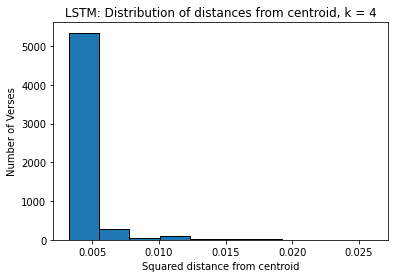

In [ ]:
# Look at the distribution of distances from centroid amoung the kmeans
plt.hist(kmeans_dist_LSTM_4.sqdist, edgecolor="black")
plt.title('LSTM: Distribution of distances from centroid, k = 4')
plt.xlabel('Squared distance from centroid')
plt.ylabel('Number of Verses')

Text(0.5, 1.0, 'LSTM: Pentateuch Spectral Clustering, k = 4')

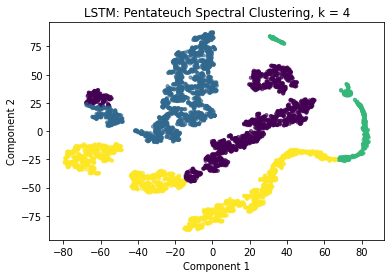

In [ ]:
# visualize clusters in t-SNE space
tsne_obj = TSNE(n_components = 2)
tsne_fit = tsne_obj.fit_transform(np.real(eigenvectors_LSTM[:,1:k]))
    
x = tsne_fit[:, 0]
y = tsne_fit[:, 1]

# use cluster labels as color in plot
plt.scatter(x, y, alpha=0.6, c=kmeans_LSTM_4.labels_, s=10)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('LSTM: Pentateuch Spectral Clustering, k = 4')

From looking at the tSNE plots of the eigenspace, it appears that the four clusters detected by spectral clustering have some overlap, and are not even in size.

##### iii. BERT Embedding

We use spectral clustering with Euclidean distance to determine the number of clusters found in the BERT embeddings, using only the first five books.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


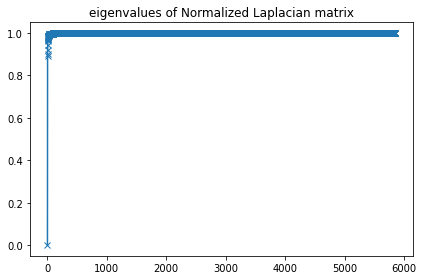

In [ ]:
eigenvals, eigenvectors = spectral_clustering_find_k(embeddings_first_5_kjv, 'euclid')

The above plot suggests that the eigenvector space has 2 clusters.

In [ ]:
# cluster in first K eigenvector space
k = 2 # for documentary hypothesis validation in Part V

kmeans_BERT = KMeans(n_clusters=k,
                n_init=5,
                copy_x=True).fit(np.real(eigenvectors[:,1:k]))
pd.Series(kmeans_BERT.labels_).value_counts()

0    3216
1    2636
dtype: int64

In [ ]:
# Save out the squared distances from the centroids for future evaluation against documentary source
kmeans_dist_BERT = kmeans_BERT.transform(np.real(eigenvectors[:,1:k]))**2
kmeans_dist_BERT = pd.DataFrame({'sqdist' : kmeans_dist_BERT.sum(axis = 1), 'labels':kmeans_BERT.labels_})


Text(0.5, 1.0, 'Pentateuch Spectral Clustering')

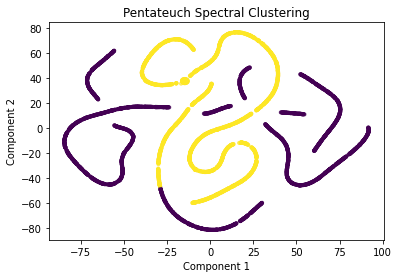

In [ ]:
# visualize clusters in t-SNE space
tsne_obj = TSNE(n_components = 2)
tsne_fit = tsne_obj.fit_transform(np.real(eigenvectors[:,1:k]))
    
x = tsne_fit[:, 0]
y = tsne_fit[:, 1]

# use cluster labels as color in plot
plt.scatter(x, y, alpha=0.6, c=kmeans_BERT.labels_, s=10)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Pentateuch Spectral Clustering')

Compared to Section III C, where we did the TSNE on the raw BERT embeddings, the TSNE plot with the eigenvectors show clear separation of clusters 1 and 0, and clusters are roughly even in size. 


<a name = 'agg'></a>
#### B. Agglomerative Clustering  

Next we performed agglomerative clustering via Ward's method on each embedding and got clustering labels to compare the results against the spectral clustering labels. 

In [ ]:
####################################################
# input: sentence embeddings
# output: dendrogram plothierarchical clusters for a single book
####################################################

def get_book_hierarchical_clusters(embedding, book):
  plt.figure(figsize=(16,8))
  idx = np.where(np.array(df['book'])==book)[0]
  embeddings = [embedding[i] for i in idx]
  dist = pdist(embeddings, metric="euclidean")
  agg_cluster_dat = hac.ward(dist)
  hac.dendrogram(agg_cluster_dat);

In [ ]:
######################################################
# input: sentence embeddings
# output: dendrogram plot of hierarchical clustering
######################################################

def get_all_hierarchical_clusters(embeddings):        
    plt.figure(figsize=(16,8))
    dist = pdist(embeddings, metric='euclidean')
    
    # plot dendrogram
    agg_cluster_dat = hac.linkage(dist, 'ward')
    hac.dendrogram(agg_cluster_dat);

In [ ]:
####################################################
# input: sentence embeddings, number of clusters
# output: Scatterplot of first two tSNE components, colored
# by agglomerative clustering labels 
####################################################
def plot_agglomerative_labels_all(embeddings, K): 
    fig = plt.figure(figsize = (16, 8))

    # get cluster labels using agglomerative clustering (Ward's)
    cluster = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(embeddings)

    # get 2-dimensional tSNE 
    tsne_obj = TSNE(n_components = 2)
    tsne_fit = tsne_obj.fit_transform(embeddings)
        
    x = tsne_fit[:, 0]
    y = tsne_fit[:, 1]
    
    # use cluster labels as color in plot
    plt.scatter(x, y, alpha=0.6, c=cluster_labels, s=40)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Pentateuch Agglomerative Clustering')

In [ ]:
######################################################
# input: sentence embeddings, number of clusters
# output: Labeled data with agglomerative cluster labels
######################################################
def get_agg_cluster_labels(cluster_num, embedding, df):

  agg_cluster = AgglomerativeClustering(n_clusters=cluster_num, affinity='euclidean', linkage='ward')
  agg_cluster_labels = agg_cluster.fit_predict(embedding)

  df_labeled = df.copy()
  df_labeled['cluster_label'] = agg_cluster_labels

  return df_labeled

##### i. Skip Gram Embedding

Hierarchical clustering results vary based on the aggregation method used for the skip gram embedding. When the verses are aggregated by taking the mean across the constituent word embeddings, hierarchical clustering indicates three potential authors, which are also well separated in the t-SNE plots.

However, when hierachical clustering is conducted on the concatanted verse embeddings, there seems to be only 2 clusters present, which are not well distinguished when visualized in the t-SNE plots. This is inconsistent with the findings from spectral clustering, which suggested three authors when the same verse embedding is used. Because the concatanated verse embeddings are 300 elements, hierarchical clustering is difficult in this high dimensional space and the results may be unreliable. Spectral clustering conducted in a lower dimensional eigenspace seems to produce more meaningful separation in the data. 

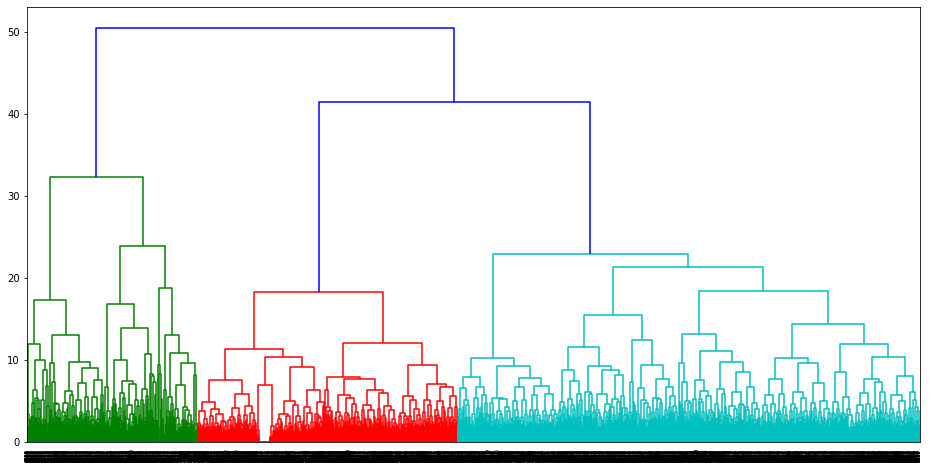

In [ ]:
get_hierarchical_clusters_all(sentence_embedding_mean)

We see that there are three clusters using agglomerative clustering (Ward's method). This could potentially indicate three different styles/authors. We can also visualize this same clustering by imposing cluster colors on a t-SNE plot.

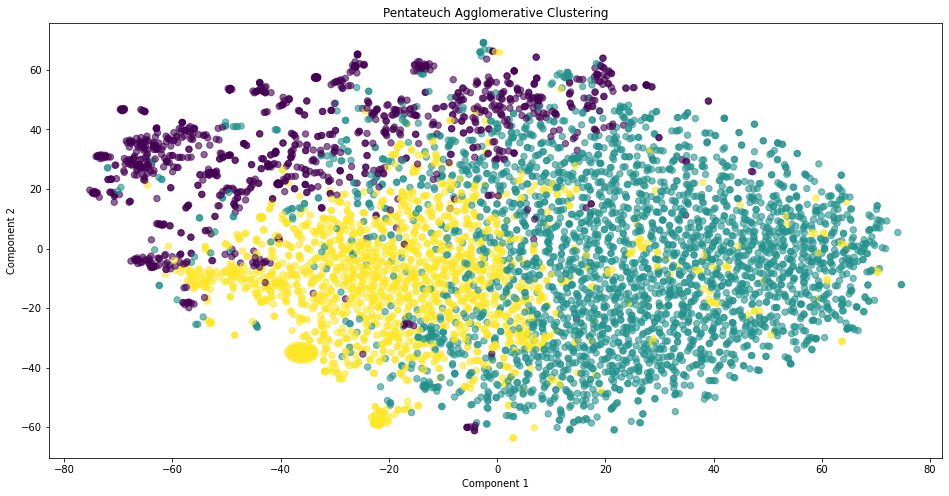

In [ ]:
# project cluster labels from hierarchical clustering onto a tSNE plot
plot_agglomerative_labels_all(sentence_embedding_mean, K=3)

In [ ]:
cluster_num = 3

agg_cluster = AgglomerativeClustering(n_clusters=cluster_num, affinity='euclidean', linkage='ward')
agg_cluster_labels = agg_cluster.fit_predict(sentence_embedding_mean)

df_pentateuch_labeled = df_first_5.copy()
df_pentateuch_labeled['cluster_label'] = agg_cluster_labels

df_pentateuch_labeled.loc[df_pentateuch_labeled.id.isin([l for l in list(df_pentateuch_labeled.id) if 'Gen10' in l])].head(10)

id  ... cluster_label
235   Gen10_1  ...             1
236   Gen10_2  ...             1
237   Gen10_3  ...             2
238   Gen10_4  ...             2
239   Gen10_5  ...             2
240   Gen10_6  ...             2
241   Gen10_7  ...             2
242   Gen10_8  ...             2
243   Gen10_9  ...             1
244  Gen10_10  ...             2

[10 rows x 4 columns]

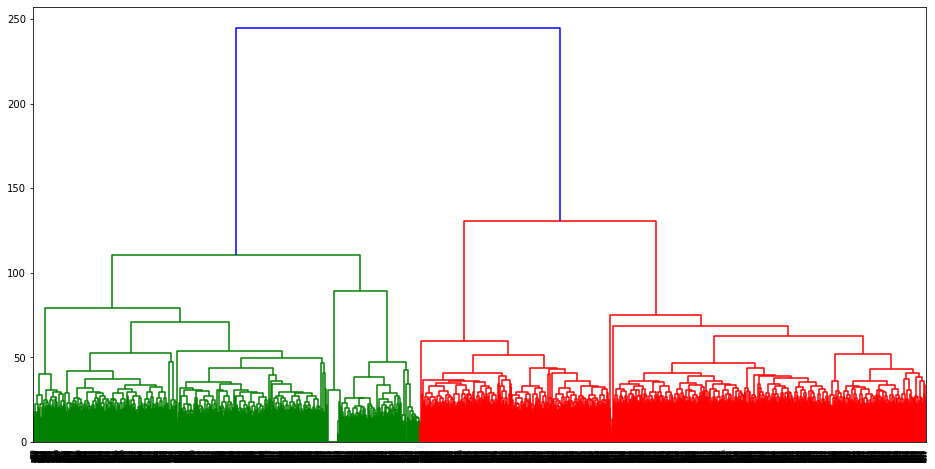

In [ ]:
get_all_hierarchical_clusters(sentence_embedding_concat)

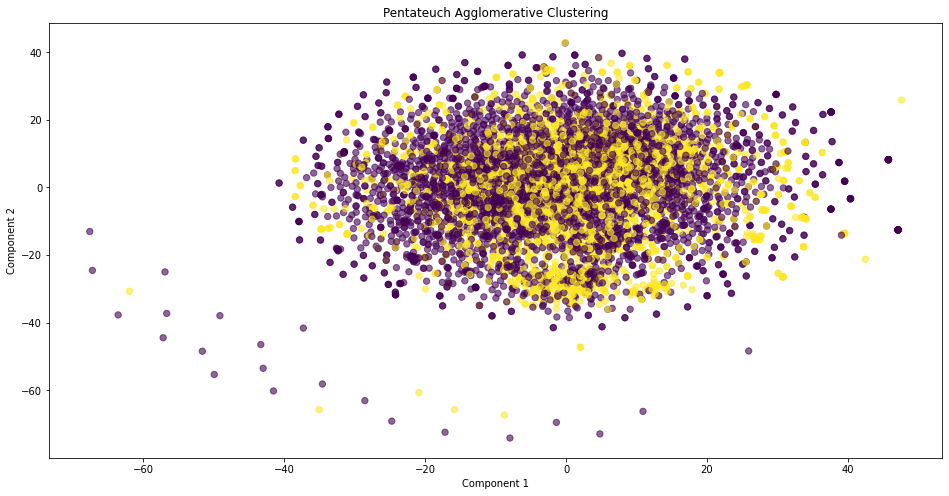

In [ ]:
# project cluster labels from hierarchical clustering onto a tSNE plot
plot_agglomerative_labels_all(sentence_embedding_concat, K=2)

In [ ]:
sgconcat_agg_labeled = get_agg_cluster_labels(2, sentence_embedding_concat, df = df_first_5)
sgconcat_agg_labeled.head()

id  ... cluster_label
0  Gen1_1  ...             1
1  Gen1_2  ...             1
2  Gen1_3  ...             1
3  Gen1_4  ...             1
4  Gen1_5  ...             2

[5 rows x 4 columns]

##### ii. LSTM Autoencoder Embedding  

We perform agglomerative clustering via Ward's method on the LSTM embedding to determine how many authors are likely to have written the first five books. Given that the spectral clustering method provided strong evidence that the LSTM embedding is identifying 4 authors, we will want to determine how much the hierarchical clustering agrees or disagrees with this. It appears that 2 clusters are well defined, and each divide pretty cleanly into two, which essentially agrees with the number of authors determined by the spectral clustering. The tSNE plot colored using the agglomerative clustering labels is not as well separated as the tSNE plot of the eigenspace colored with spectral clustering above, so spectral clustering seems to be a more effective clustering method to separate out styles.

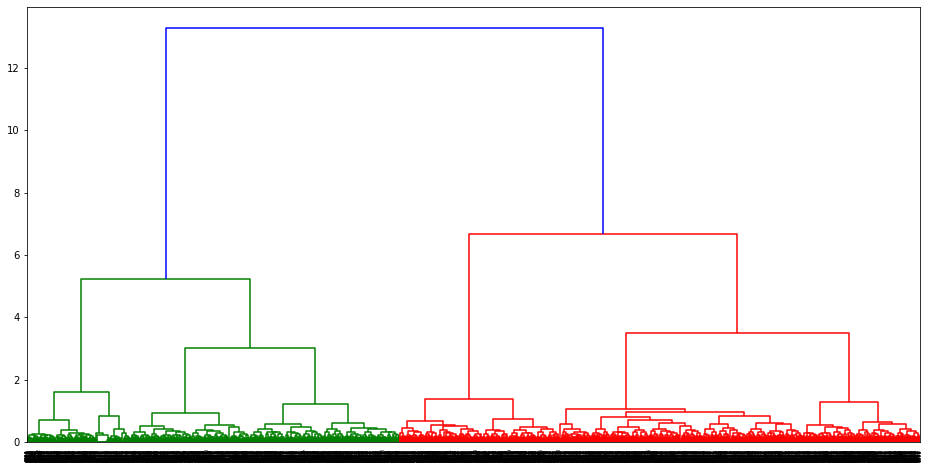

In [ ]:
get_all_hierarchical_clusters(latent_LSTM_5)

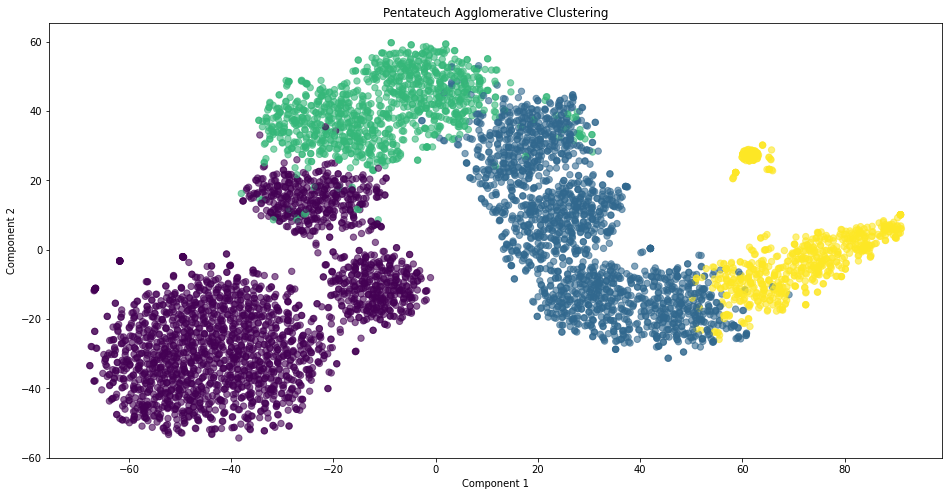

In [ ]:
plot_agglomerative_labels_all(latent_LSTM_5, K=4)

In [ ]:
LSTM_agg_labeled = get_agg_cluster_labels(4, latent_LSTM_5, df = df_first_5)

In [ ]:
LSTM_agg_labeled.head()

id  ... cluster_label
0  Gen1_1  ...             0
1  Gen1_2  ...             0
2  Gen1_3  ...             0
3  Gen1_4  ...             0
4  Gen1_5  ...             0

[5 rows x 4 columns]

##### iii. BERT Embedding

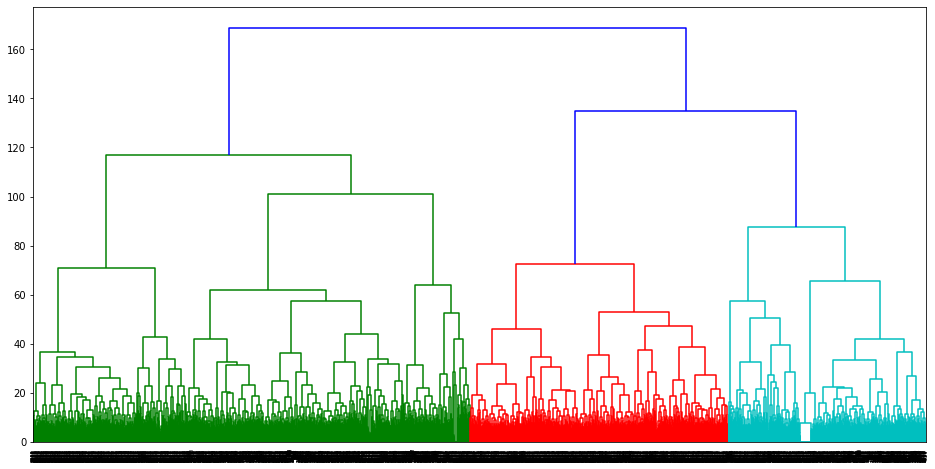

In [ ]:
get_all_hierarchical_clusters(embeddings_first_5_kjv)

Performing agglomerative clustering with Ward's method on the BERT embeddings apears to result in 2 well separated clusters, and 1 cluster can potentially be further split into 2 clusters.

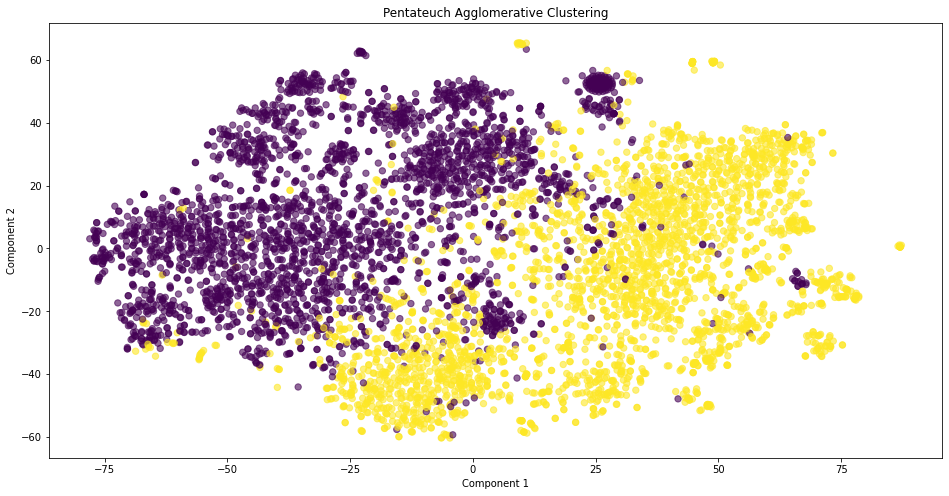

In [ ]:
plot_agglomerative_labels_all(embeddings_first_5_kjv, K=2)

In [ ]:
# first 5
df_first_5_kjv = df_kjv.loc[df_kjv.book.isin(['Gen', 'Exo', 'Lev', 'Num', 'Deu'])]

BERT_agg_labeled = get_agg_cluster_labels(2, embeddings_first_5_kjv, df = df_first_5_kjv)
BERT_agg_labeled

id  ... cluster_label
0       Gen1_1  ...             1
1       Gen1_2  ...             1
2       Gen1_3  ...             1
3       Gen1_4  ...             1
4       Gen1_5  ...             1
...        ...  ...           ...
5847   Deu34_8  ...             1
5848   Deu34_9  ...             1
5849  Deu34_10  ...             1
5850  Deu34_11  ...             1
5851  Deu34_12  ...             1

[5852 rows x 4 columns]

<a name = 'eval'></a>
### V. Evaluation

There are two key components of our methodology that we need to validate. 

(A) We need to evaluate whether our embeddings are capturing important stylistic elements that would be unique to an author, and not just semantic content.

(B) After the text is embedded, we need to evaluate whether our clustering methodology can successfully group verses by unique authors. Note, the general spectral clustering methodology was validated on artificial text in Section IV A. above.

In order to validate our embeddings in both Parts A & B, we will be referring to the [documentary hypothesis](https://en.wikiversity.org/wiki/Bible/King_James/Documentary_Hypothesis). This hypothesis states that four groups of authors (denoted by J/E/P/D) wrote the Torah which was then edited together by a redactor R, based on the King James translation of the Bible. We will see if we can recreate some of these source delineations with our embeddings and clusterings. 

The chart below outlines how the five sources form each book. We can see that Leviticus and Deuteronomy are the most "pure" books, in the sense that the overwhelming majority of the text are from a single source (Priestly and Deuteronomist, respectively). Additionally, Genesis has 4 primary contributors (J,E,P, & R).

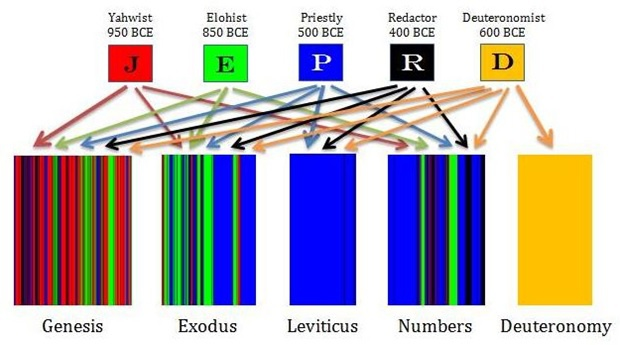

<a name = 'labels'></a>
##### A. Evaluate Embeddings - Supervised Label Prediction 
In order to determine the strength of the relationship between our embeddings and our labels, we created a simple feed forward network model that essentially just passes our embeddings through an output Dense layer and predicts the classes. We train this model using the labels (which correspond to different authors) presumed to be true based on the documentary hypothesis. A high test set accuracy indicates that the embeddings have a strong relationship with the labels we are testing, and thus may be capturing sytlistic elements that would be unique to each of the authors proposed by biblical scholars.


In [ ]:
####################################################
# input: sentence embeddings, labels
# output: test set accuracy for a simple FFNN with only an output dense layer
####################################################
def get_FFNN_accuracy(model_name, embedding, labels, test_size, input_size, output_nodes, 
                      epochs, batch_size, output_summary = True):
  print('Fitting a FFNN for a', model_name, '...')
  # One hot encode the y values
  labels_set = sorted(list(set(labels)))
  labels2idx = {label: i for i, label in enumerate(labels_set)}
  y = [labels2idx[a] for a in labels]
  y = to_categorical(y)
  # Create train test split
  X_train,  X_test, y_train, y_test = train_test_split(embedding, y, test_size = test_size)

  # Define model
  pred_model = tf.keras.Sequential()
  pred_model.add(tf.keras.layers.Input(shape = input_size))
  pred_model.add(tf.keras.layers.Flatten())
  pred_model.add(tf.keras.layers.Dense(128, activation = 'relu'))
  pred_model.add(tf.keras.layers.Dense(output_nodes, activation = 'softmax'))

  # Compile model
  pred_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  if output_summary:
    pred_model.summary()

  # Fit model
  print('Model is now fitting (verbose = 0)...')
  pred_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 0)

  print('Generating test accuracy...')
  # Get test set accuracy
  test_acc = pred_model.evaluate(X_test, y_test, verbose = 0)
  print(f'The test accuracy is: {round(test_acc[1], 4)}')
  return 



In [ ]:
####################################################
# input: sentence embeddings, kmeans distances from centroids and labels
# output: test set accuracy for a simple FFNN with only an output dense layer
# Trains on given percentage of closets labels to centroids
####################################################
def get_FFNN_accuracy_KNN(model_name, embedding, labels, dist, 
                          pct_threshold, input_size, output_nodes, epochs, 
                          batch_size, output_summary = True):
  
  print('Fitting a FFNN for a', model_name, '...')

  # Get train test split thresholds
  threshold = np.quantile(sorted(dist.sqdist), pct_threshold)
  train_ind = np.where(dist.sqdist <= threshold)[0]
  test_ind = np.where(dist.sqdist > threshold)[0]

  print('Number of training samples: ', len(train_ind))
  print('Number of testing samples: ', len(test_ind))

  # Make train-test split
  X_train = embedding[train_ind, :]
  X_test = embedding[test_ind, :]

  # Create y and make train-test split
  labels_set = sorted(list(set(labels)))
  labels2idx = {label: i for i, label in enumerate(labels_set)}
  y = [labels2idx[a] for a in labels]
  y = to_categorical(y)

  y_train = y[train_ind, :]
  y_test = y[test_ind, :]


  # Define model
  pred_model = tf.keras.Sequential()
  pred_model.add(tf.keras.layers.Input(shape = input_size))
  pred_model.add(tf.keras.layers.Flatten())
  #pred_model.add(tf.keras.layers.Dense(10, activation = 'relu'))
  pred_model.add(tf.keras.layers.Dense(output_nodes, activation = 'softmax'))

  # Compile model
  pred_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  if output_summary:
    pred_model.summary()

  # Fit model
  print('Model is now fitting (verbose = 0)...')
  pred_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 0)

  print('Generating test accuracy...')
  # Get test set accuracy
  test_acc = pred_model.evaluate(X_test, y_test, verbose = 0)
  print(f'The test accuracy is: {round(test_acc[1], 4)}')

  return

In [ ]:
# read in labeled verses based on Documentary hypothesis
doc_labels = pd.read_excel(project_directory + 'document_source_label.xlsx')
doc_labels.head()

Book  Chapter                                              Verse Source
0  Gen        1  1In the beginning God created the heaven and t...      P
1  Gen        1  2And the earth was without form, and void; and...      P
2  Gen        1  3And God said, Let there be light: and there w...      P
3  Gen        1  4And God saw the light, that it was good: and ...      P
4  Gen        1  5And God called the light Day, and the darknes...      P

###### i. Skip Gram

The skip-gram embedding is able to predict the authors for each verse hypothesized by the documentary theory in Chapters 1 - 35 of Genesis with 60% accuracy when a simple Feed-Forward Neural Network is used.  

A more informed training method was also attempted where instead of making a random train/test split, the data points closer to the cluster centers (created via k-means in the spectral clustering) were used for training. This is based on the assumption that these training points are clustered with more confidence and would thus, more accurately correspond to the author dilineations posed by the documentary hypothesis. The remaining points were then used to test on. However, the results from this approach are actually slightly worse than the random train/test split, achieving only 53% accuracy.

For a classification task aimed at identifying 4 authors (J, E, P and Redactor source), random assignment would have resulted in 25% accuracy, and so the performance of the skip gram embedding surpasses this rate. 

In [ ]:
doc_source_labels = doc_labels.Source.values
n_labels = len(doc_source_labels)
model_name = 'Skipgram Embedding with Documentary Source labels'
get_FFNN_accuracy(model_name, 
                  sentence_embedding_concat[:n_labels], 
                  doc_source_labels, 
                  0.1, (300,), 4, 10, math.floor(n_labels/5), 
                  output_summary = False)

Fitting a FFNN for a Skipgram Embedding with Documentary Source labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.6


In [ ]:
# Kmeans with 80% threshold
model_name = 'Skipgram Embedding with Documentary Source labels, training on the 25% closest labels to the centroids'
get_FFNN_accuracy_KNN(model_name, 
                      sentence_embedding_concat[:n_labels], 
                      doc_source_labels, 
                      kmeans_dist_skip[:n_labels], .8, 
                      (300,), 4, 
                      30, math.floor(n_labels/5), 
                      output_summary = True)

Fitting a FFNN for a Skipgram Embedding with Documentary Source labels, training on the 25% closest labels to the centroids ...
Number of training samples:  833
Number of testing samples:  208
Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_148 (Flatten)        (None, 300)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 4)                 1204      
Total params: 1,204
Trainable params: 1,204
Non-trainable params: 0
_________________________________________________________________
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.5288


In [ ]:
# Kmeans labels
model_name = 'Skip gram with kmeans clustering labels'
get_FFNN_accuracy(model_name, 
                  sentence_embedding_concat, 
                  kmeans_skip.labels_, 
                  0.2, (300,), 3, 20, 50, 
                  output_summary = False)

# # Kmeans with 50% threshold
model_name = 'Skip gram with kmeans clustering labels, training on the 25% closest labels to the centroids'
get_FFNN_accuracy_KNN(model_name, 
                      sentence_embedding_concat, 
                      kmeans_skip3.labels_, 
                      kmeans_dist_skip3, .5, 
                      (300,), 3, 
                      20, 50, 
                      output_summary = False)


Fitting a FFNN for a Skip gram with kmeans clustering labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.9633
Fitting a FFNN for a Skip gram with kmeans clustering labels, training on the 25% closest labels to the centroids ...
Number of training samples:  2927
Number of testing samples:  2926
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.9809


###### ii. LSTM Autoencoder  

We performed the same classification task with the first 35 chapters of Genesis labeled using the documentary hypothesis above with the LSTM embedding and achieved a test set accuracy of 50%. With four possible sources, this is evidence that the embeddings are capturing some about of power to predict the source as labeled in the documentary hypothesis (if it had no predictive power this would be around 25%). Performing this classification task training on only the 80% closests points to their respective spectral clustering centroids, we achieved a slightly higher accuracy of 53.3%.  

Last we performed this classification task by simply getting a test set accuracy while trying to predict the clustering labels generative via spectral clustering and agglomerative clustering. In both scenarios the test set accuracy was higher than 98%, which we would expect, and which gives a strong indication that these are well defined clusters in the embedding.

In [ ]:
# Documentary hypothesis accuracy
doc_source_labels = doc_labels.Source.values
n_labels = len(doc_source_labels)
model_name = 'LSTM embedding with Documentary Source labels'
get_FFNN_accuracy(model_name, 
                  latent_LSTM_5[:n_labels], 
                  doc_source_labels, 
                  0.1, (40,), 4, 10, math.floor(n_labels/5), 
                  output_summary = False)

Fitting a FFNN for a LSTM embedding with Documentary Source labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.6


In [ ]:
# Kmeans with 80% threshold
model_name = 'LSTM embedding with Documentary Source labels, training on the 80% closest labels to the spectral clustring k-means centroids'
get_FFNN_accuracy_KNN(model_name, 
                      latent_LSTM_5[:n_labels], 
                      doc_source_labels, 
                      kmeans_dist_LSTM_4[:n_labels], .8, 
                      (40,), 4, 
                      30, math.floor(n_labels/5), 
                      output_summary = False)

Fitting a FFNN for a LSTM embedding with Documentary Source labels, training on the 80% closest labels to the spectral clustring k-means centroids ...
Number of training samples:  833
Number of testing samples:  208
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.5481


In [ ]:
# Kmeans labels
model_name = 'LSTM autoencoder with kmeans clustering labels'
get_FFNN_accuracy(model_name, 
                  latent_LSTM_5, 
                  kmeans_LSTM_4.labels_, 
                  0.2, (40,), 4, 20, 50, 
                  output_summary = False)


# Agglomerative clustering labels
LSTM_agg_labeled =  get_agg_cluster_labels(4, latent_LSTM_5, df_first_5)
model_name = 'LSTM autoencoder with agglomerative clustering labels'
get_FFNN_accuracy(model_name, 
                  latent_LSTM_5, 
                  LSTM_agg_labeled['cluster_label'], 
                  0.3, (40,), 4, 20, 50, 
                  output_summary = False)

Fitting a FFNN for a LSTM autoencoder with kmeans clustering labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.9838
Fitting a FFNN for a LSTM autoencoder with agglomerative clustering labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.9727


###### iii. BERT

In [ ]:
doc_source_labels = doc_labels.Source.values
n_labels = len(doc_source_labels)
model_name = 'BERT Embedding with Documentary Source labels'
get_FFNN_accuracy(model_name, 
                  embeddings_first_5_kjv[:n_labels], 
                  doc_source_labels, 
                  0.1, (768,), 4, 10, math.floor(n_labels/5), #test_size, input_size, output_nodes, epochs, batch_size
                  output_summary = False)

Fitting a FFNN for a BERT Embedding with Documentary Source labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.5619


The BERT embedding can predict the authors for each verse hypothesized by the documentary theory in Chapters 1-35 of Genesis with only 56% accuracy. 

In [ ]:
# Kmeans labels
model_name = 'BERT with kmeans clustering labels'
get_FFNN_accuracy(model_name, 
                  embeddings_first_5_kjv, 
                  kmeans_BERT.labels_, 
                  0.2, (768,), 2, 10, 50, #test_size, input_size, output_nodes, epochs, batch_size
                  output_summary = False)



Fitting a FFNN for a BERT with kmeans clustering labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.9915


In [ ]:
# Agglomerative clustering labels
model_name = 'BERT with agglomerative clustering labels'
get_FFNN_accuracy(model_name, 
                  embeddings_first_5_kjv, 
                  BERT_agg_labeled['cluster_label'], 
                  0.3, (768,), 2, 10, 50, 
                  output_summary = False)

Fitting a FFNN for a BERT with agglomerative clustering labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.9282


In [ ]:
# Kmeans with 25% threshold
model_name = 'BERT with kmeans clustering labels, training on the 25% closest labels to the centroids'
get_FFNN_accuracy_KNN(model_name, 
                      embeddings_first_5_kjv, 
                      kmeans_BERT.labels_, 
                      kmeans_dist_BERT, .2, 
                      (768,), 2, 
                      10, 50, 
                      output_summary = False)

Fitting a FFNN for a BERT with kmeans clustering labels, training on the 25% closest labels to the centroids ...
Number of training samples:  1171
Number of testing samples:  4681
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.9947


We have obtained a very high test accuracy, indicating that BERT embeddings have a strong relationship with the labels tested. Of course, this is to be expected. A more robust evaluation will be done with an artificial text, as follows. 

<a name = 'artifical'></a>
##### B. Evaluate Embeddings & Clustering - Artificial Text Generation
In order to validate that our embeddings are capturing stylistic differences, we performed an artificial text generation to see if our different embeddings can capture the number of authors in a mix text correctly.  

We mix two texts together and determine if the model is able to:  

1. Correctly identify the number of authors.  
2. Identify the authors as the books they are attributed to  

According to the Documentary Hypothesis, Deuteronomy was mostly written by the Deuteronomist, while Leviticus primarily comes from the "Priestly" source. Therefore, we are going to see how closely our embeddings can separate these two books as two separate sources, with supposedly known authors. 
 


In [ ]:
# Artificial Text Generator
# - Randomly mixes given books of the bible together
# - Need to pass in the desired chunk sizes which will be chosen at random
# - Manually set number of iterations (this can be changed to when a book runs out)
def artificialText(iter, books, chunks, data_all):
  # Make a dictionary of the books
  text_books = {b:data_all.loc[data_all['book'] == b] for b in books}

  mix = pd.DataFrame()
  for i in range(iter):
    # Chooses a random chunk
    excp = np.random.choice(chunks)
    # Subsets the given dataframe text for the selected book and the excerpt lines
    excp_df = text_books[books[i % len(books)]].iloc[0:excp]
    # update book to not have the text
    mix = pd.concat([mix, excp_df], axis = 0)
    text_books[books[i % len(books)]] = text_books[books[i % len(books)]].iloc[excp:]
  return mix

In [ ]:
# mix_test = artificialText(100, ['Deu', 'Lev'], [5,10,12], df)

In [ ]:
# mix_test.to_csv(project_directory + 'artificial_text.csv')

In [ ]:
mix_test = pd.read_csv(project_directory + 'artificial_text.csv')

In [ ]:
mix_test.groupby('book').chapter.count()

book
Deu    455
Lev    498
Name: chapter, dtype: int64

In [ ]:
# Preprocess and pad
txt_mix = [l.split() for l in mix_test['text']]
# Encode using words from the whole corpus
txt_encode_mix = [[word2idx[w] for w in v] for v in txt_mix]
X_mix = pad_sequences(txt_encode_mix, maxlen=max_len_trunc, padding = 'post', value = word2idx['ENDPAD'])

###### i. Skip Gram

In [ ]:
num_verses, max_verse_len = X_mix.shape
skipgram_X_mix = word2vec_embedding.numpy()[X_mix.flatten(), :].reshape(num_verses, max_verse_len, -1)

In [ ]:
# skipgram mean
#skipgram_X_mix_mean = skipgram_X_mix.mean(axis=1)

# skipgram concatenated
skipgram_X_mix_concat = skipgram_X_mix.reshape(num_verses, - 1)
skipgram_X_mix_concat.shape

(953, 300)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


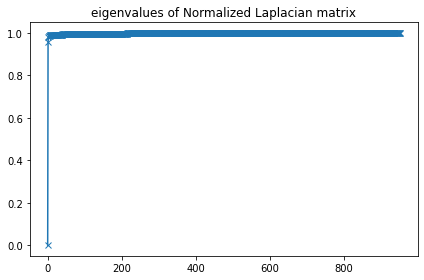

In [ ]:
eigenvals_skip_mix, eigenvectors_skip_mix = spectral_clustering_find_k(skipgram_X_mix_concat)

In [ ]:
k = 2

kmeans_skip_mix = KMeans(n_clusters=k,
                n_init=40,
                copy_x=True).fit(np.real(eigenvectors_skip_mix[:,1:k]))
print(pd.Series(kmeans_skip_mix.labels_).value_counts())

0    533
1    420
dtype: int64


In [ ]:
pd.DataFrame({'actual': mix_test['book'], 
              'kmeans':kmeans_skip_mix.labels_, 'val':1}).groupby(['actual', 'kmeans']).count()

val
actual kmeans     
Deu    0       272
       1       183
Lev    0       261
       1       237

In [ ]:
## Accuracy calculation idea:
# Largest subset above is "correct"
(282+227)/len(mix_test)

0.534102833158447

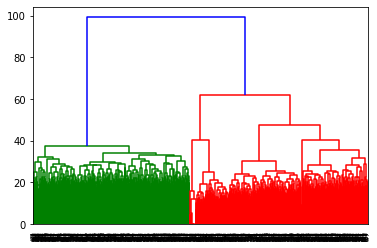

In [ ]:
pdist_SG_mix = pdist(skipgram_X_mix_concat, metric="euclidean")
agg_cluster_dat_sg = hac.ward(pdist_SG_mix)
hac.dendrogram(agg_cluster_dat_sg);

In [ ]:
# Get lables using fclusters
SG_agg_labeled_mix = get_agg_cluster_labels(2, skipgram_X_mix_concat, df = mix_test)

In [ ]:
SG_agg_labeled_mix.groupby(['book', 'cluster_label']).text.count().reset_index()

book  cluster_label  text
0  Deu              0   215
1  Deu              1   240
2  Lev              0   293
3  Lev              1   205

In [ ]:
## Accuracy calculation idea:
# Largest subset above is "correct"
(280+225)/len(mix_test)

0.5299055613850997

In [ ]:
# Perform FFNN accuracy 
model_name = 'Skip Gram embedding with Artifical Text labels'
get_FFNN_accuracy(model_name, 
                  skipgram_X_mix_concat, 
                  mix_test['book'], 
                  0.1, (300,), 2, 10, 100, 
                  output_summary = False)

Fitting a FFNN for a Skip Gram embedding with Artifical Text labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.7083


After embedding the artificial text using the skip-gram embedded layer, both the spectral clustering and agglomerative clustering methods are able to correctly identify that the text constructed with verses from Deuteronomy and Leviticus should be clustered into two groups. However, neither clustering method is able to confidently differentite between the two authors, and each cluster is composed of verses originating from both books.    

###### ii. LSTM Autoencoder

Run artificial text through the autoencoder and see how many clusters it comes up with.

In [ ]:
# Embedding layer
embed_X_mix = embed_model.predict(X_mix)
print(embed_X_mix.shape)

# Get LSTM Autoencoder latent space
latent_LSTM_mix = autoencoder_latent.predict(embed_X_mix)

(953, 15, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


CPU times: user 2.28 s, sys: 901 ms, total: 3.18 s
Wall time: 1.67 s


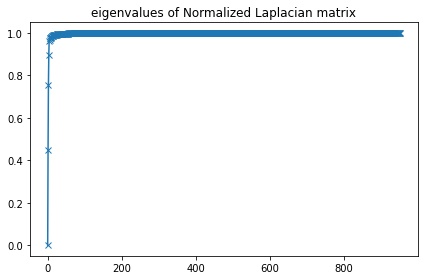

In [ ]:
# Perform Spectral clustering
%%time
eigenvals_LSTM_mix_euclid, eigenvectors_LSTM_mix_euclid = spectral_clustering_find_k(latent_LSTM_mix)


In [ ]:
# Perform k means
# cluster in first K eigenvector space
k = 2

kmeans_LSTM_mix = KMeans(n_clusters=k,
                n_init=40,
                copy_x=True).fit(np.real(eigenvectors_LSTM_mix_euclid[:,1:k]))
print(pd.Series(kmeans_LSTM_mix.labels_).value_counts())

0    561
1    392
dtype: int64


In [ ]:
pd.DataFrame({'actual': mix_test['book'], 
              'kmeans':kmeans_LSTM_mix.labels_, 
              'val':1}).groupby(['actual', 'kmeans']).count()

val
actual kmeans     
Deu    0       281
       1       174
Lev    0       280
       1       218

In [ ]:
## Accuracy calculation idea:
# Largest subset above is "correct"
(291+210)/len(mix_test)

0.5257082896117523

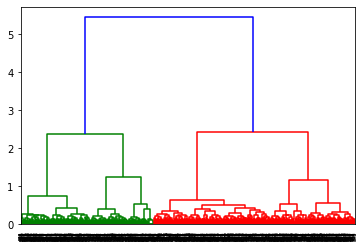

In [ ]:
pdist_LSTM_mix = pdist(latent_LSTM_mix, metric="euclidean")
agg_cluster_dat = hac.ward(pdist_LSTM_mix)
hac.dendrogram(agg_cluster_dat);

In [ ]:
# Get lables using fclusters
LSTM_agg_labeled_mix = get_agg_cluster_labels(2, latent_LSTM_mix, df = mix_test)

In [ ]:
LSTM_agg_labeled_mix.groupby(['book', 'cluster_label']).text.count().reset_index()

book  cluster_label  text
0  Deu              0   286
1  Deu              1   169
2  Lev              0   287
3  Lev              1   211

In [ ]:
## Accuracy calculation idea:
# Largest subset above is "correct"
(261+235)/len(mix_test)

0.5204616998950682

In [ ]:
# Perform FFNN accuracy 
model_name = 'LSTM embedding with Artifical Text labels'
get_FFNN_accuracy(model_name, 
                  latent_LSTM_mix, 
                  mix_test['book'], 
                  0.1, (40,), 2, 10, 100, 
                  output_summary = False)

Fitting a FFNN for a LSTM embedding with Artifical Text labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.5833


Through both spectral clustering and hierarchical clustering on the LSTM autoencoder embedding determine the correct number of authors in this demonstration, they do not seem to identify the different souces as delineated by the documentary hypothesis. This is possibly happening because the embedding is picking up on different stylistic differences than those that distinguish between two authors.

###### iii. BERT

In [ ]:
mix_test.head()

Unnamed: 0      id  ...  book                                               text
0        4894  Deu1_1  ...   Deu  alh hdbry~ avr dbr mvh al-kl-yfral b[br hyrd! ...
1        4895  Deu1_2  ...   Deu            axd [fr yw~ mxrb dr$ hr-f[yr [d qdvbrn[
2        4896  Deu1_3  ...   Deu  wyhy barb[y~ vnh b[vty-[fr xdv baxd lxdv dbr m...
3        4897  Deu1_4  ...   Deu  axry hktw at syx! ml$ hamry avr ywvb bxvbw! wa...
4        4898  Deu1_5  ...   Deu  b[br hyrd! bar# mwab hwayl mvh bar at-htwrh hz...

[5 rows x 5 columns]


We will extract the embeddings using BERT to see how many clusters it comes up with. 

In [ ]:
# Initialize the model
model_kjv = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_kjv.eval()

# Convert the mix artificial text to embeddings

# track the time
t0 = time.time()

# store the set of embeddings
bible_embeddings_kjv = []
num_verse = len(mix_test)
print('Generating sentence embeddings for all {:,} verses...'.format(num_verse))

row_num = 0

# for each row of the dataframe
for index, row in mix_test.iterrows():
    
    #progress report every 2000 verses
    if row_num % 2000 == 0 and not row_num == 0:
        #calculate time remaining based on progress
        rows_per_sec = (time.time()-t0)/row_num
        remaining_sec = rows_per_sec*(num_verse - row_num)
        print('Verse{:>7,} of {:>7,}. Remaining:{:} seconds'.format(row_num,num_verse,remaining_sec))
        
    #vectorize the verse
    vec = text_to_embedding(tokenizer, model_kjv,row.text)
    
    #store the embeddings
    bible_embeddings_kjv.append(vec)
    
    row_num += 1

# convert list of vectors into a 2D array
vecs_kjv = np.stack(bible_embeddings_kjv)
vecs_kjv.shape

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generating sentence embeddings for all 953 verses...


(953, 768)

In [ ]:
# save those embeddings
output_dir = project_directory +'/bert_embeddings/'
print('Output directory is: ', output_dir)

# create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# use numpy to write out the matrix of embeddings
print('Saving embeddings to: ./bert_embeddings/embeddings_kjvmix.npy')
file_name = output_dir + 'embeddings_kjvmix.npy'
np.save(file_name, vecs_kjv)

Output directory is:  drive/MyDrive/CS109B Final Project//bert_embeddings/
Saving embeddings to: ./bert_embeddings/embeddings_kjvmix.npy


In [ ]:
embeddings_kjvmix = project_directory +'/bert_embeddings/embeddings_kjvmix.npy'
embeddings_kjvmix = np.load(embeddings_kjvmix)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


CPU times: user 2.37 s, sys: 1 s, total: 3.37 s
Wall time: 1.89 s


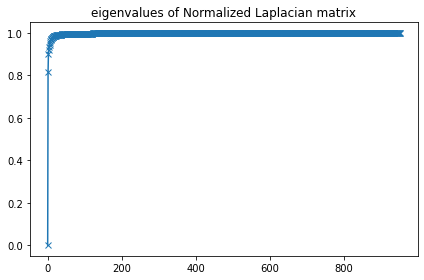

In [ ]:
# Perform Spectral clustering
%%time
eigenvals_BERT_mix_euclid, eigenvectors_BERT_mix_euclid = spectral_clustering_find_k(embeddings_kjvmix)


Spectral clustering again sugggests that 2 or 3 clusters are identified. Suppose we set k = 2:

In [ ]:
# Perform k means
# cluster in first K eigenvector space
k = 2

kmeans_BERT_mix = KMeans(n_clusters=k,
                n_init=40,
                copy_x=True).fit(np.real(eigenvectors_BERT_mix_euclid[:,1:k]))
print(pd.Series(kmeans_BERT_mix.labels_).value_counts())

1    620
0    333
dtype: int64


In [ ]:
pd.DataFrame({'actual': mix_test['book'], 'kmeans':kmeans_BERT_mix.labels_, 'val':1}).groupby(['actual', 'kmeans']).count()

val
actual kmeans     
Deu    0       207
       1       248
Lev    0       126
       1       372

In [ ]:
## Accuracy calculation idea:
# Largest subset above is "correct"
(207+372)/len(mix_test)

0.6075550891920252

We have achieved good validation accuracy with BERT embeddings for Leviticus. With Deuteronomy the performance is not great. However, note that the stochasiticity does play a role here. When using different mix text, we obtain varying results. 

Again, we try agglomerative clustering on the embeddings and see if the resulting classification makes any difference. 

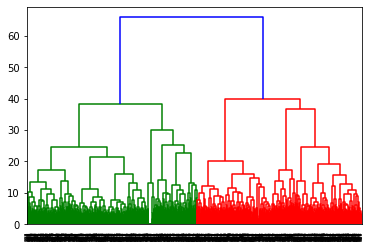

In [ ]:
pdist_BERT_mix = pdist(embeddings_kjvmix, metric="euclidean")
agg_cluster_dat = hac.ward(pdist_BERT_mix)
hac.dendrogram(agg_cluster_dat);

Hierarchical clustering has identified 2 clusters, i.e. 2 authors. 

In [ ]:
# Get lables using fclusters
BERT_agg_labeled_mix = get_agg_cluster_labels(2, embeddings_kjvmix, df = mix_test)
BERT_agg_labeled_mix.groupby(['book', 'cluster_label']).text.count()

book  cluster_label
Deu   0                254
      1                201
Lev   0                215
      1                283
Name: text, dtype: int64

In [ ]:
## Accuracy calculation idea:
# Largest subset above is "correct"
(254+283)/len(mix_test)

0.5634837355718783

The accuracy is around 56% on the mixed text. However, as we run through different mix text randomly generated, this figure could go as high as 80%.  

In [ ]:
# Perform FFNN accuracy 
model_name = 'BERT embedding with Artifical Text labels'
get_FFNN_accuracy(model_name, 
                  embeddings_kjvmix, 
                  mix_test['book'], 
                  0.1, (768,), 2, 10, 100, 
                  output_summary = False)

Fitting a FFNN for a BERT embedding with Artifical Text labels ...
Model is now fitting (verbose = 0)...
Generating test accuracy...
The test accuracy is: 0.875


On the artificial text labels, we have achieved an accuracy of 87.5% with BERT embeddings. This suggests that we are indeed benefiting from the transfer learning with BERT, and that studying the English text may as well offer great advantage in uncovering linguistic features. 

<a name = 'results'></a>
### VI. Results

#### i. Skip Gram Embedding

In [ ]:
df_first_5['skip_gram'] = kmeans_skip3.labels_
df_first_5.to_csv(project_directory + 'temp.csv')
df_first_5.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


id chapter  ...                                               text skip_gram
0  Gen1_1       1  ...                 bravyt bra alhy~ at hvmy~ wat har#         0
1  Gen1_2       1  ...  whar# hyth thw wbhw wxv$ [l-pny thw~ wrwx alhy...         0
2  Gen1_3       1  ...                       wyamr alhy~ yhy awr wyhy-awr         2
3  Gen1_4       1  ...  wyra alhy~ at-hawr ky-jwb wybdl alhy~ by! hawr...         0
4  Gen1_5       1  ...  wyqra alhy~ lawr yw~ wlxv$ qra lylh wyhy-[rb w...         0

[5 rows x 5 columns]

The spectral clustering results for the skip-gram embedded verses indicated that there are three distinct authors for the first five books of the Hebrew Bible. Below, we have a visual comparison of the spectral clustering labels with the documentary hypothesis labels. 

When comparing the spectral clustering results on the verses embedded using skip-gram, there are some verses that align with the documentary hypothesis dilineations. However, the skip gram/ spectral clustering approach results in groupings (see Hebrew Verse column colored by cluster labels) that are not as well batched as the documentary hypothesis labels(see English Verse column colored by documentary source). The clustering labels seem to switch between authors at much higher frequency than seems reasonable.

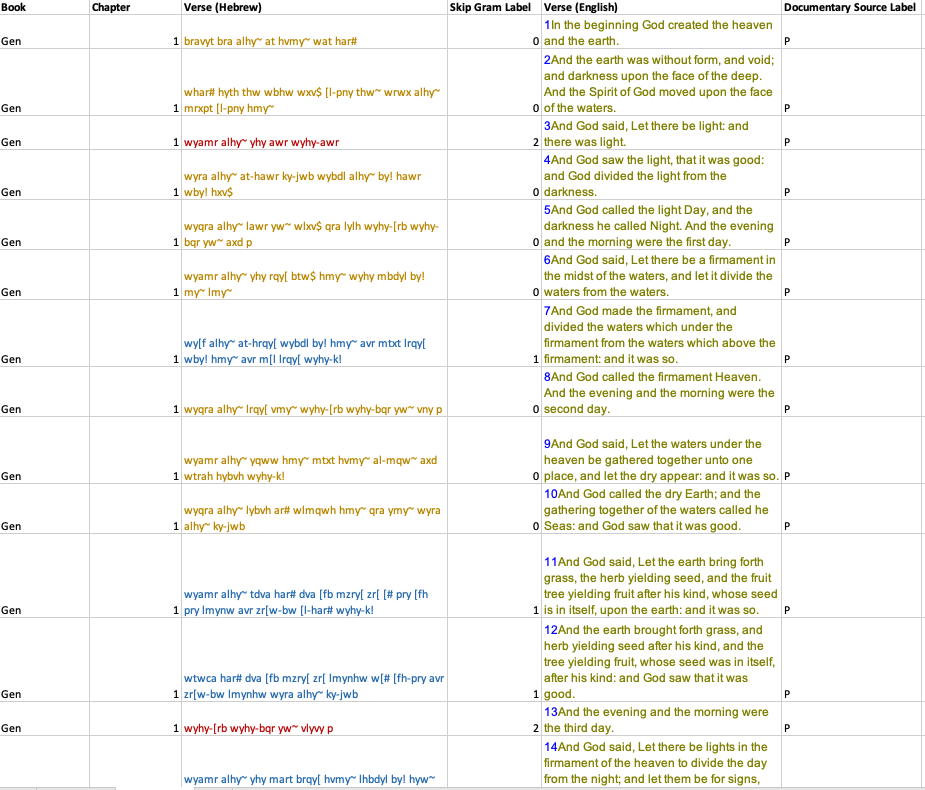

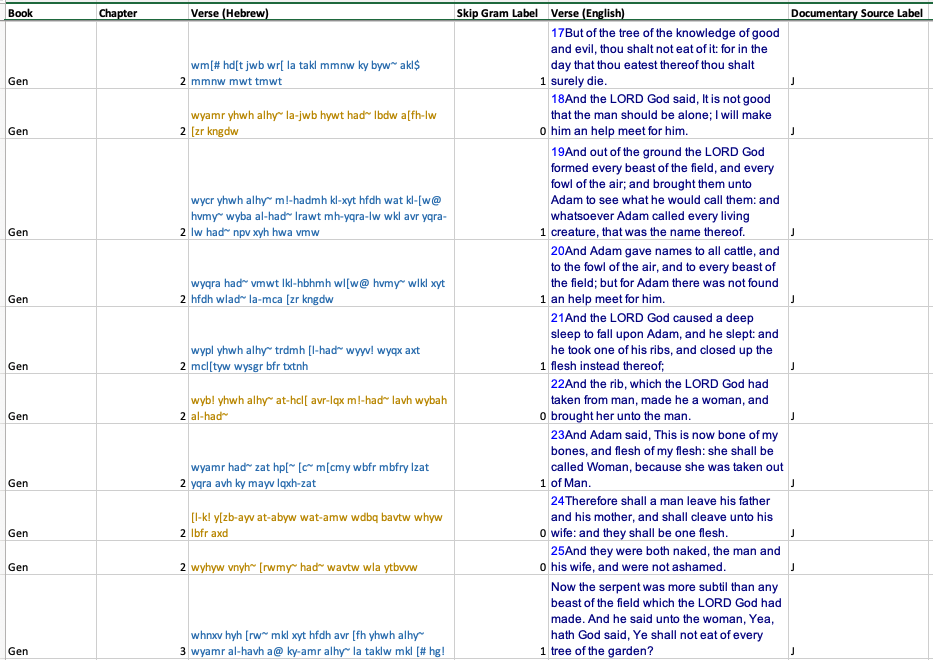

#### ii. LSTM Embedding  

Similar to the skipgram model, we present a few excerpts of the comparison of the LSTM embedding spectral clustering labels to the documentary hypothesis labels. We similarly see a high rate of changing authors predicted by the LSTM model, much higher than the documentary hypothesis.

In [ ]:
lstm_spectrum_labels = df_first_5.copy()
lstm_spectrum_labels['spectral_label'] = kmeans_LSTM_4.labels_
lstm_spectrum_labels.to_csv(project_directory + 'LSTM_labels.csv')

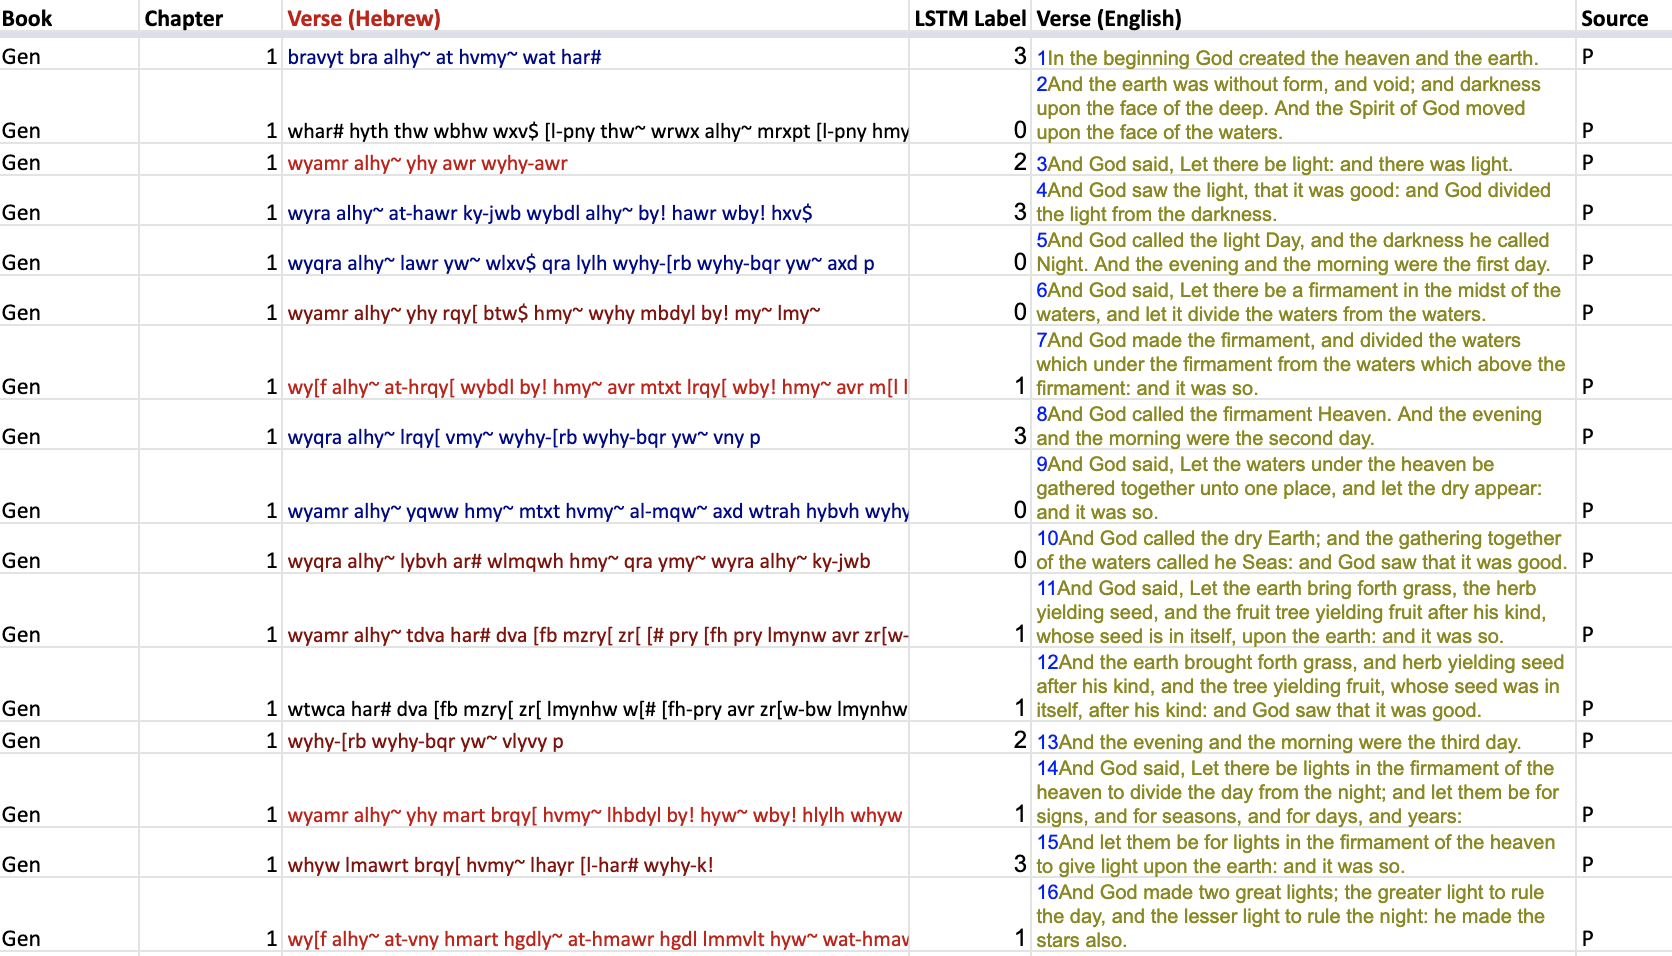

#### iii. BERT Embedding 

Similarly, we show the classification by BERT embeddings, for the first 5 books. 

BERT's classification tends to be slightly more layered than the biblical sources. However, there are also chunks where both leads to similar judgement, especially on the transition of authors beween verses.

We provided snippets of the classification for reference. 

In [ ]:
BERT_spectrum_labels = df_first_5_kjv.copy()
BERT_spectrum_labels['spectral_label'] = kmeans_BERT.labels_
BERT_spectrum_labels.to_csv('BERT_labels.csv', project_directory + 'BERT_labels.csv')

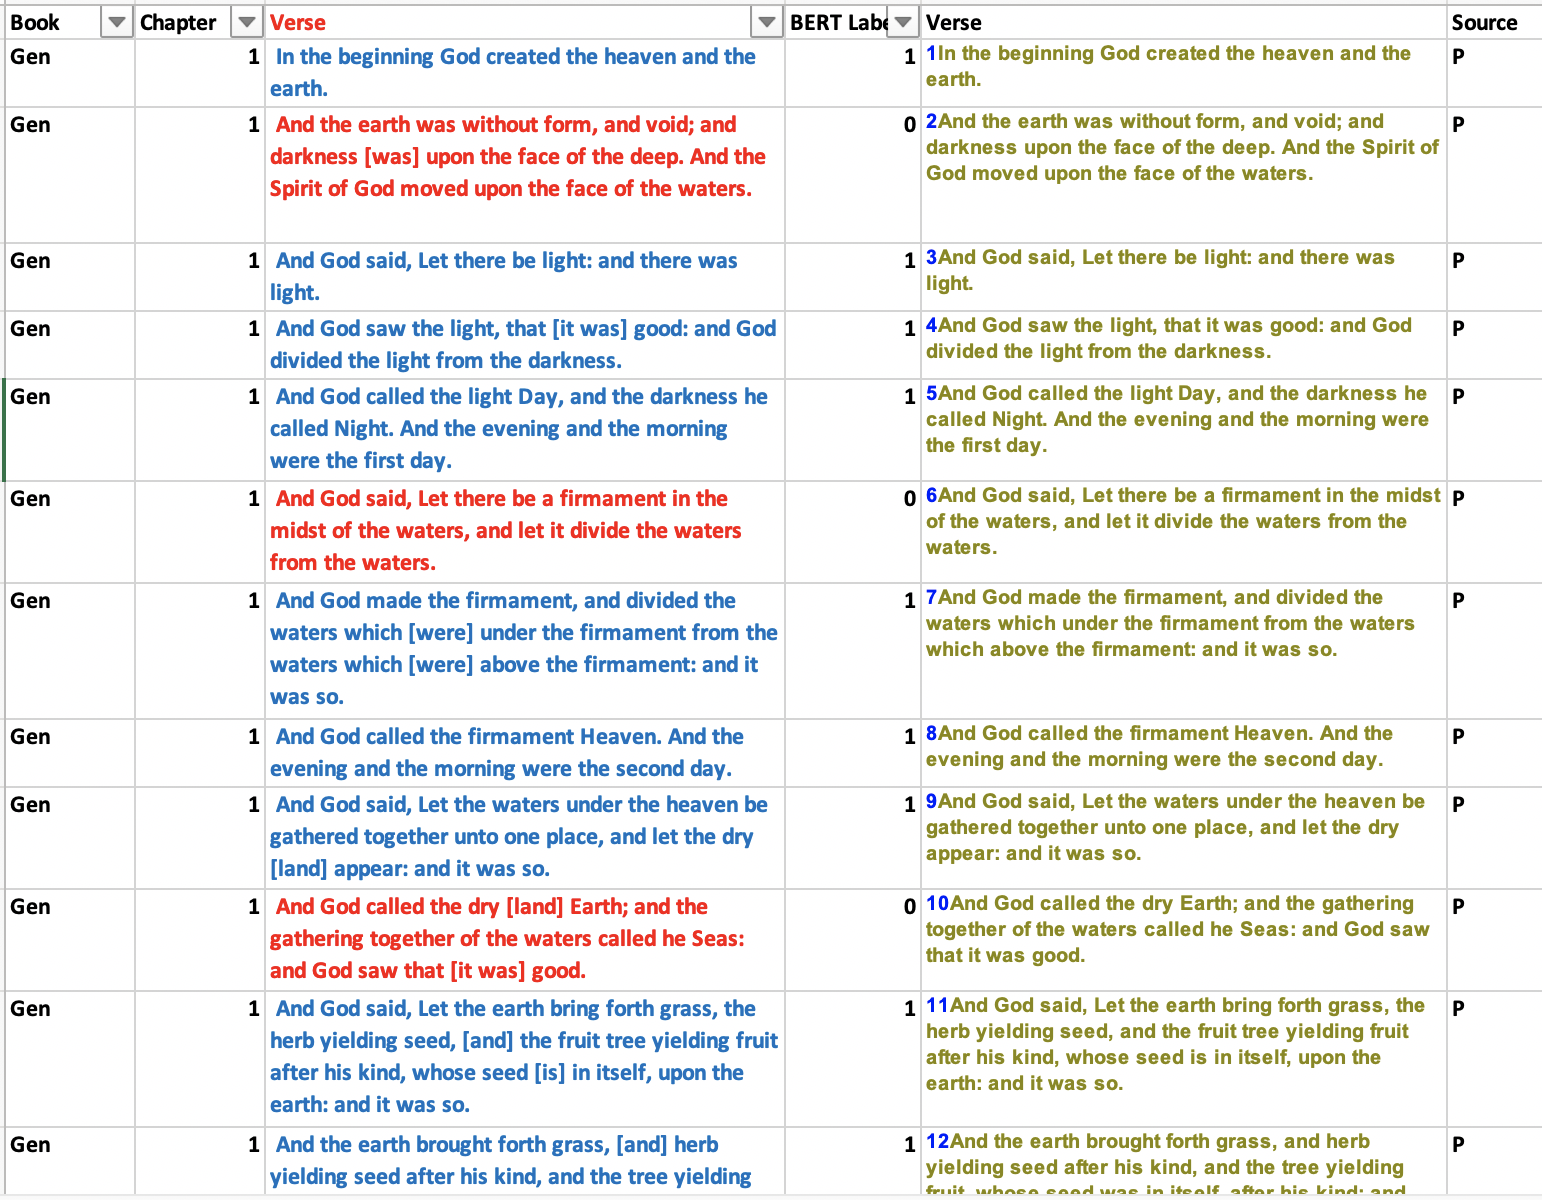

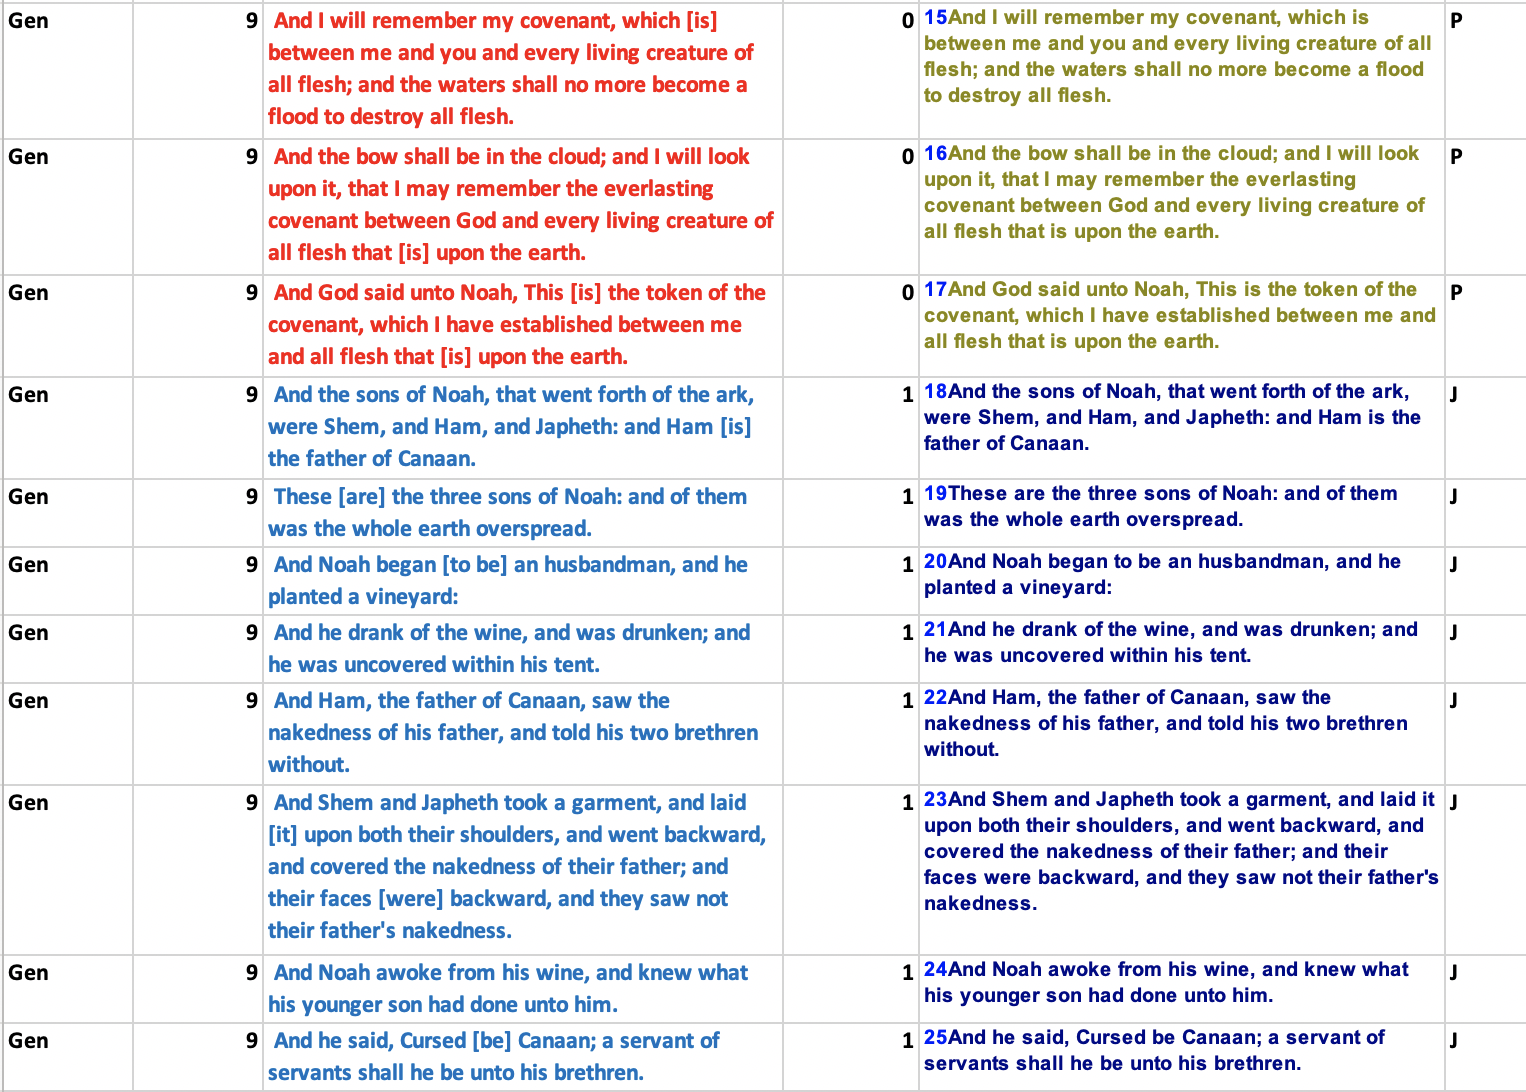

<a name = 'discussion'></a>
### VII. Discussion   

*Strengths*

Our study has extensive exploration on three types of word embeddings, generated from both the Hebrew and the English bible. In addition, we adopted both spectral and agglomerative clustering for the unsupervised classification, which is unseen in previous publications. 

We validated our models using an approach similar to Koppel and Akiva, in which a supervised model is built based on the result of the unsupervised classification. We also tested the robustness of the result on a randomly mixed text. 

At the end, we also provided snippets of the generated clusters to compare with the biblical sources. This can provide reference for future studies. 


*Limitations*

The limitations of the embedding models from **Skip-Gram** is that it is originally designed to predict synonyms for a given word, rather than a given sentence. While we made appropriate aggregations of the embedding vectors to try to predict similarity between verses, the model is not actually designed to predict verse similarity. Additionally, in the absence of labeled data, we were forced to create couplets for each verse separately; if labeled data was available, we could have trained over multiple verses and used a wider window for broader context.  

For the **LSTM** embeddings, we would expect the embedding to capture verse structure well, however it performed similarly enough to the skip-gram model that it may not have actually been doing a great job of capturing verse structure in its layer. This may have been improved upon with a deeper autoencoder, as the one we created for this task only had one layer. 

For **BERT** embeddings, since the model process one verse at the time, it is possible that the context-based embeddings obtained are based on the verses, not the whole bible corpus. Although we have seen excellent performance of the BERT embeddings in the evaluation, this limitation may have hindered us in producing an even better representation of the text features.  

A greater limitation comes from the way embeddings are used. While our objective is to determine the authorship of the text, we assume that each author will have their own distinct style. The embeddings however, capture not only the stylistic differences, but also the content differences. We are not able to control what aspects the embeddings can extract, as they are meant to represent overall features of the verses. 

Another limitation includes the fact that there is no inherent right answer for the unsupervised text classification. It is also difficult to understand why certain sentences are attributed to one author, but not the other. This is also the limitation that we have observed in many previous published work on this topic. We are relying on the heuristics of the embeddings or other feature extraction methods, without being able to make linguistic or lexical interpretations. 

*How to improve*

Common to most NLP problems, enlarging the corpus may provide more meaningful contextual information, especially for the skip-gram model. Future studies could also focus on building a connection between the word embeddings and their linguistic characteristics, so that we can understand what features lead to the classification. For example, an RNN model can be built, in which we can visualize which word or phrases are activated for the classification. Additionally, lower level character embeddings could provide meaningful information on punctuation usage and part of speech identification could be used to analyze sentence structures. Richer ensemble methods considering the various facets of linguistic characteristics could improve overall performance.